<!-- Notebook Header Start -->

<h1 align="center">Changes to Noxious Stimuli by means of Dorsal Root Ganglion Stimulation</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-12-06<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Importing libraries & data**
* **Preprocess neurophysiology recordings for spike sorting**
* **Package preprocessed data for spike sorting using Kilosort4**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during noxious stimuli**
* **Compare the firing rates of clusters before and after noxious stimuli**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# ➡ Importing Libraries & Data
---

In [1]:
# standard imports
from pathlib import Path
import os
from kilosort import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots
from automations import analysis_functions


### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
PROBE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')

### filepath definitions

In [3]:
# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# save data to the inbox; make sure that the folders: binary & figures exist

# select your path

# the following save directory has already been run, and it stores data that has been unaltered
SAVE_DIRECTORY = Path(fr"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.010 Mult_Rat_Linear_Mixed_Effects") 


# Create paths if they don't exist
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)


# run a multi-rat class

In [4]:
rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW322', 'DW323', 'DW327']]
group = RM1.RatGroup(rats)
group.run_preprocessing()  # preprocess all rats at once

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233: stream_id 2 is not in ['0', '1', '3', '4']
Re

In [5]:
group.rats.keys()

dict_keys(['DW322', 'DW323', 'DW327'])

## run spikeinterface

In [6]:
si_wrappers = group.create_spikeinterface_wrappers(SAVE_DIRECTORY)
for rat_id in si_wrappers.keys():
    # si_wrappers[rat_id].save_spinalcord_data_to_binary()
    pass

Preparing SpikeInterface wrapper for rat DW322
Preparing SpikeInterface wrapper for rat DW323
Preparing SpikeInterface wrapper for rat DW327


## kilosort

In [7]:
ks_wrappers = group.create_kilosort_wrappers(SAVE_DIRECTORY, probe_directory=PROBE_DIRECTORY)
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):
    # Example criteria: Contamination rate < 0.1 and firing rate between 0.5 and 50 Hz
    contam_good = est_contam_rate < 0.2
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.5 <= fr <= 50:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

Preparing Kilosort wrapper for DW322
Preparing Kilosort wrapper for DW323
Preparing Kilosort wrapper for DW327


In [ ]:
for rat_id in ks_wrappers.keys():
    ks_wrappers[rat_id].run_kilosort_trial_summary(new_settings="vf_settings",custom_criteria=my_custom_criteria)
    ks_wrappers[rat_id].extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_1_240918_143256
Kilosort outputs successfully loaded for trial: VF_2_240918_143936
Kilosort outputs successfully loaded for trial: VF_3_240918_144658
Kilosort outputs successfully loaded for trial: VF_4_240918_145638
Kilosort outputs successfully loaded for trial: VF_5_240918_150137
Kilosort outputs successfully loaded for trial: VF_6_240918_150811
Kilosort outputs successfully loaded for trial: VF_7_240918_151516
Kilosort outputs successfully loaded for trial: VF_8_240918_152056
Kilosort outputs successfully loaded for trial: VF_9_240918_152753
Kilosort outputs successfully loaded for trial: VF_1_240911_164342
Kilosort outputs successfully loaded for trial: VF_2_240911_165039
Kilosort outputs successfully loaded for trial: VF_3_240911_165617
Kilosort outputs successfully loaded for trial: VF_4_240911_170446
Kilosort outputs successfully loaded for trial: VF_5_240911_171014
Kilosort outputs successfully loaded for trial: VF_6_240911_17

### multi-animal von frey analysis

In [9]:
# Create a multi–rat analysis instance.
multi_analysis = analysis_functions.MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)

# combine all the trials from every animal to plot the results

combined_results = multi_analysis.analyze_all_trials(excel_parent_folder=SAVE_DIRECTORY, subwindow_width=0.5, corr_threshold=0.1)

# use combined_results for further plotting or modeling.

# combined_results now contains results from each rat, loaded from Excel if available.

In [10]:
combined_results["DW322_VF_2_240918_143936"]

{'voltage_df':      avg_voltage      group
 0   272278.37500   pre-stim
 1   289338.81250   pre-stim
 2   274101.43750   pre-stim
 3   227150.00000   pre-stim
 4   288529.34375   pre-stim
 ..           ...        ...
 65  617659.06250  post-stim
 66  664856.37500  post-stim
 67  763105.62500  post-stim
 68  820236.31250  post-stim
 69  646114.18750  post-stim
 
 [70 rows x 2 columns],
 'firing_df':        Unnamed: 0          0          1           2           3          4  \
 0               0  48.000000  36.000000   24.000000   26.000000  68.000000   
 1               1  52.000000  62.000000  114.000000   46.000000  80.000000   
 2               2   0.000000   0.000000    0.000000    0.000000   0.000000   
 3               3   0.000000   0.000000  150.000000  150.000000   0.000000   
 4               4  76.000000  34.000000   62.000000   48.000000  16.000000   
 ..            ...        ...        ...         ...         ...        ...   
 67             67  14.000000  36.000000    8.

Combine the Results and Metadata:
You would need to create (or extract) a DataFrame where each row corresponds to a sub-window (or trial) with columns for the dependent variable (for example, average voltage), the fixed effects (e.g. stimulation, pulse width, waiting), and a column indicating the animal (rat ID). You might need to merge your VonFreyAnalysis results with metadata that specifies stimulation parameters.

Fit a Mixed Effects Model:
Use the statsmodels MixedLM or the formula interface (statsmodels.formula.api.mixedlm) to specify a model with fixed effects for voltage, stimulation, pulse width, waiting and a random intercept for animal.


### example of single-rat experiment properties

In [11]:
group.rats["DW323"].qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,NaN
Trial Number,,,,,,,,,,,
1,1,VF,70,300,5,180,vf,NaN,30,pos 1,pad just prximal from toe
2,2,VF,70,300,20,180,vf,NaN,30,pos 1,NaN
3,3,VF,70,300,100,180,vf,NaN,30,pos 1,NaN
4,4,VF,70,300,100,180,vf,NaN,30,pos 2,toes
5,5,VF,70,300,5,180,vf,NaN,30,pos 2,NaN
6,6,VF,70,300,20,180,vf,NaN,30,pos 2,NaN


### combining the experiment notes for individual animals, for combined plots and linear mixed effects modeling.

In [12]:
def make_unique_cols(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    df.columns = new_cols
    return df

dfs = []
for rat_id, rat in group.rats.items():
    df = make_unique_cols(rat.qst_trial_notes.copy())
    df['Rat ID'] = rat_id
    df["Trial Number"] = rat_id + "_" + df["Trial Number"].astype(str)
    dfs.append(df)

combined_qst_notes = pd.concat(dfs, ignore_index=True)

# Sort keys based on the numeric part after the second underscore (i.e., the zero-padded trial number)
sorted_keys = sorted(
    combined_results.keys(),
    key=lambda x: int(x.split('_')[2])
)

combined_qst_notes['Trial_ID'] = sorted_keys

# After concatenating your DataFrames into combined_qst_notes:
combined_qst_notes['Trial_ID'] = list(combined_results.keys())
combined_qst_notes

,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,Rat ID,nan_1,Trial_ID
0,DW322_1,VF,51,300,5,180,vf,NaN,30,accidentally named DRGS_13,DW322,NaN,DW322_VF_1_240918_143256
1,DW322_2,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_2_240918_143936
2,DW322_3,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_3_240918_144658
3,DW322_4,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_4_240918_145638
4,DW322_5,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_5_240918_150137
5,DW322_6,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_6_240918_150811
6,DW322_7,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_7_240918_151516
7,DW322_8,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_8_240918_152056
8,DW322_9,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_9_240918_152753
9,DW323_1,VF,70,300,5,180,vf,NaN,30,pos 1,DW323,pad just prximal from toe,DW323_VF_1_240911_164342


## plot a composite Von Frey Analysis plot

Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_6_240918_150811. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_

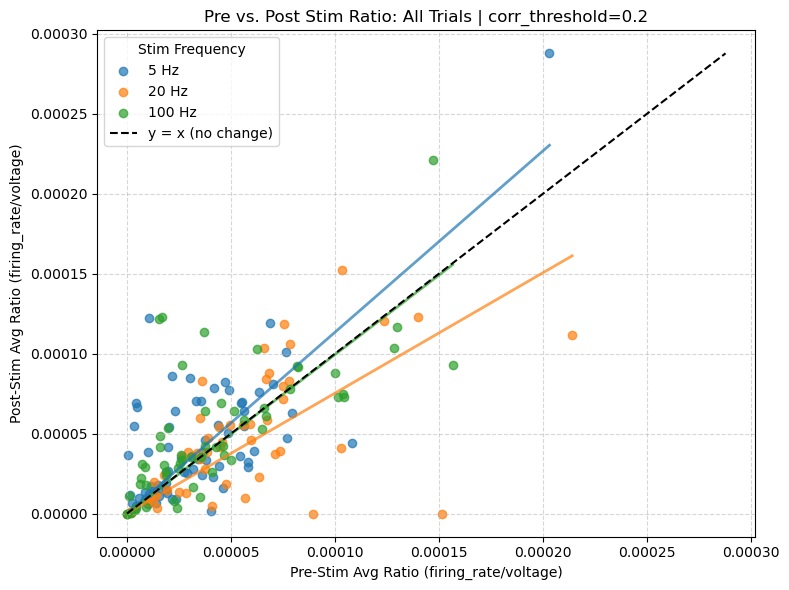

In [13]:
# For example:
plots.vf_all_trials_combined_plot(combined_results, combined_qst_notes,corr_threshold=0.2)

## combine metadata and neuron firing changes for linear effects mixed model

In [14]:
def flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.1):
    """
    Flattens trial data into a single DataFrame, then filters clusters by correlation threshold.
    Only clusters whose absolute correlation meets or exceeds corr_threshold are kept.
    """
    # Create dictionaries for columns you need from combined_qst_notes
    freq_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Freq. (Hz)']))
    amp_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['amp']))
    # Add a rat_id_dict to capture the rat ID from combined_qst_notes
    rat_id_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Rat ID']))
    pulse_width_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['PW (us)']))



    records = []

    for trial_id, res in combined_results.items():
        # Get frequency and amplitude
        freq_hz = freq_dict.get(trial_id)
        amp_val = amp_dict.get(trial_id)
        rat_id = rat_id_dict.get(trial_id)
        pulse_width = pulse_width_dict.get(trial_id)

        if freq_hz is None or amp_val is None or rat_id is None or pulse_width is None:
            continue

        avg_voltage_df = res.get('voltage_df')
        firing_rates_df = res.get('firing_df')
        if avg_voltage_df is None or firing_rates_df is None:
            continue
        
        # Skip if not enough rows to have correlation data
        if len(firing_rates_df) < 2:
            continue

        # Extract the correlation row (second-to-last row)
        correlation_data = firing_rates_df.iloc[-2]
        # Convert correlation entries to a dictionary keyed by integer cluster IDs
        corr_dict = {
            int(k): v
            for k, v in correlation_data.to_dict().items()
            if str(k).isdigit()
        }

        # Exclude the last two rows (correlation row, plus any extra row if present)
        firing_data = firing_rates_df.iloc[:-2]

        # Melt the firing data to long format: (group, cluster, firing_rate)
        firing_melt = firing_data.melt(
            id_vars=['group'], 
            var_name='cluster', 
            value_name='firing_rate'
        )
        firing_melt['cluster'] = pd.to_numeric(firing_melt['cluster'], errors='coerce')

        # Merge firing data with average voltage on group
        if "avg_voltage" not in avg_voltage_df.columns:
            continue
        merged_df = pd.merge(
            firing_melt,
            avg_voltage_df[["group", "avg_voltage"]],
            on="group",
            how="left"
        )

        # Map correlation values per cluster
        merged_df['correlation'] = merged_df['cluster'].map(corr_dict)

        # Add identifying columns
        merged_df['Trial_ID'] = trial_id
        merged_df['Frequency_Hz'] = freq_hz
        merged_df['Amplitude'] = amp_val
        merged_df["Pulse_Width(us)"] = pulse_width
        # normalize the results by dividing by average voltage
        merged_df["firing_rate_vs_stim(uV^-1)"] = merged_df['Frequency_Hz'] / merged_df["avg_voltage"]
        merged_df['Rat_ID'] = rat_id
        
        # Collect all in a list
        records.append(merged_df)

    # Combine all into a single DataFrame
    if not records:
        return pd.DataFrame()

    final_long_df = pd.concat(records, ignore_index=True)

    # Filter by correlation threshold. Keep only those meeting abs corr >= threshold
    final_long_df = final_long_df[final_long_df['correlation'].abs() >= corr_threshold]

    return final_long_df


lmem = flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.01)
lmem.to_csv(SAVE_DIRECTORY / "export.csv")
lmem

,group,cluster,firing_rate,avg_voltage,correlation,Trial_ID,Frequency_Hz,Amplitude,Pulse_Width(us),firing_rate_vs_stim(uV^-1),Rat_ID
2592,pre-stim,0.0,0.0,226600.000000,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2593,pre-stim,0.0,0.0,226881.562500,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2594,pre-stim,0.0,0.0,243538.781250,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000021,DW322
2595,pre-stim,0.0,0.0,226158.921875,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2596,pre-stim,0.0,0.0,251939.531250,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000020,DW322
...,...,...,...,...,...,...,...,...,...,...,...
1444950,post-stim,13.0,0.0,483454.500000,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000010,DW327
1444951,post-stim,13.0,0.0,391476.812500,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000013,DW327
1444952,post-stim,13.0,0.0,514316.093750,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000010,DW327
1444953,post-stim,13.0,0.0,542111.687500,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000009,DW327


## alternative method: output the change in average firing rate for each neuron

In [15]:
def flatten_percent_change_by_corr_percent_change(combined_results, combined_qst_notes, corr_threshold=0.1):
    """
    For each (Trial_ID, cluster), compute:
    1) The ratio (firing_rate / avg_voltage) for each time window.
    2) Average the ratio separately for pre-stim and post-stim.
    3) Compute percent change: 100 * (post_ratio - pre_ratio) / pre_ratio
       (If pre_ratio = 0, skip or set to NaN.)
    4) Return one row per (Trial_ID, cluster) with the percent change and relevant metadata.
    
    Only clusters whose absolute correlation meets or exceeds corr_threshold are kept.
    """
    # Build dictionaries from combined_qst_notes
    freq_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Freq. (Hz)']))
    amp_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['amp']))
    rat_id_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Rat ID']))
    pulse_width_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['PW (us)']))

    # Temporary storage of all rows before grouping
    all_rows = []

    for trial_id, res in combined_results.items():
        freq_hz = freq_dict.get(trial_id)
        amp_val = amp_dict.get(trial_id)
        rat_id = rat_id_dict.get(trial_id)
        pulse_width = pulse_width_dict.get(trial_id)

        # Skip if any required metadata is missing
        if freq_hz is None or amp_val is None or rat_id is None or pulse_width is None:
            continue

        avg_voltage_df = res.get('voltage_df')
        firing_rates_df = res.get('firing_df')
        if avg_voltage_df is None or firing_rates_df is None:
            continue
        if len(firing_rates_df) < 2:
            continue

        # Extract correlation dictionary (second-to-last row)
        correlation_data = firing_rates_df.iloc[-2]
        corr_dict = {
            int(k): v
            for k, v in correlation_data.to_dict().items()
            if str(k).isdigit()
        }

        # Exclude last two rows (correlation row, plus extra if present)
        firing_data = firing_rates_df.iloc[:-2]

        # Reshape to long format (group, cluster, firing_rate)
        firing_melt = firing_data.melt(
            id_vars=['group'],
            var_name='cluster',
            value_name='firing_rate'
        )
        firing_melt['cluster'] = pd.to_numeric(firing_melt['cluster'], errors='coerce')

        # Join with avg_voltage on group
        if "avg_voltage" not in avg_voltage_df.columns:
            continue
        merged_df = pd.merge(
            firing_melt,
            avg_voltage_df[['group', 'avg_voltage']],
            on='group',
            how='left'
        )

        # Keep only clusters that meet the correlation threshold
        merged_df['correlation'] = merged_df['cluster'].map(corr_dict)
        merged_df = merged_df[merged_df['correlation'].abs() >= corr_threshold]

        # Compute ratio = firing_rate / avg_voltage
        merged_df['ratio'] = merged_df['firing_rate'] / merged_df['avg_voltage']

        # Add identifying columns
        merged_df['Trial_ID'] = trial_id
        merged_df['Frequency_Hz'] = freq_hz
        merged_df['Amplitude'] = amp_val
        merged_df['Pulse_Width(us)'] = pulse_width
        merged_df['Rat_ID'] = rat_id
        merged_df["group"] 

        # Collect
        all_rows.append(merged_df)

    # If no valid data, return empty
    if not all_rows:
        return pd.DataFrame()

    # Combine everything into one DataFrame
    big_df = pd.concat(all_rows, ignore_index=True)

    # Now, group by (Trial_ID, cluster, group) and average ratio
    # We'll pivot so we get columns for each group (pre-stim, post-stim, etc.)
    grouped = big_df.groupby(['Trial_ID', 'cluster', 'Rat_ID', 'Amplitude', 'Frequency_Hz', 'Pulse_Width(us)', 'group'])['ratio'].mean()

    # Convert the grouped series to a DataFrame with columns for each group
    pivoted = grouped.unstack('group')  # Each group becomes a column
    # For example, pivoted might have columns ["post-stim", "pre-stim"] if those are your group labels

    # We'll assume your group column has "pre-stim" and "post-stim". Adjust if needed.
    # If a trial is missing one of these, you'll see NaN there.
    pivoted = pivoted.rename_axis(columns=None).reset_index()

    # Suppose your group labels are "pre-stim" and "post-stim". We'll compute percent change:
    # (post_ratio - pre_ratio) / pre_ratio * 100
    # If pre_ratio is zero or NaN, you might get an inf or NaN result, so handle carefully.
    def compute_percent_change(row):
        ratio_pre = row.get('pre-stim', np.nan)
        ratio_post = row.get('post-stim', np.nan)
        if pd.isna(ratio_pre) or ratio_pre == 0:
            return np.nan
        return 100 * (ratio_post - ratio_pre) / ratio_pre

    pivoted['percent_change'] = pivoted.apply(compute_percent_change, axis=1)

    return pivoted


# Usage example:
lmem_percent = flatten_percent_change_by_corr_percent_change(combined_results, combined_qst_notes, corr_threshold=0.01)

# Each row now corresponds to (Trial_ID, cluster) with columns:
# ['Trial_ID', 'cluster', 'Rat_ID', 'Amplitude', 'Frequency_Hz', 'Pulse_Width(us)', 'pre-stim', 'post-stim', 'percent_change']

# NOTE: the post-stim and pre-stim columns are in units: Hz / uV

lmem_percent.head()


,Trial_ID,cluster,Rat_ID,Amplitude,Frequency_Hz,Pulse_Width(us),post-stim,pre-stim,percent_change
0,DW322_VF_1_240918_143256,0.0,DW322,51,5,300,0.000088,0.000047,88.229267
1,DW322_VF_1_240918_143256,1.0,DW322,51,5,300,0.000039,0.000041,-3.091632
2,DW322_VF_1_240918_143256,3.0,DW322,51,5,300,0.000086,0.000023,274.059750
3,DW322_VF_1_240918_143256,4.0,DW322,51,5,300,0.000035,0.000027,32.435144
4,DW322_VF_1_240918_143256,5.0,DW322,51,5,300,0.000054,0.000031,78.316838


# 📈 linear mixed effects models - trial 1

In [16]:
# Rename the column to something without parentheses or minus signs
df = lmem.copy()
df.rename(columns={"firing_rate_vs_stim(uV^-1)": "firing_rate_vs_stim"}, inplace=True)

# Ensure 'group' & "Rat ID" are recognized as categorical variables
df['group'] = df['group'].astype('category')
df["Rat_ID"] = df["Rat_ID"].astype("category")

# # Now you can write the formula more cleanly
# model = smf.mixedlm(
#     # formula="firing_rate_vs_stim ~ avg_voltage + Amplitude + Frequency_Hz + C(group)",
#     formula="firing_rate_vs_stim ~ group + Frequency_Hz",
#     data=df,
#     groups=df["Rat_ID"]
# )

# result = model.fit()
# print(result.summary())


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_standardize = ["Amplitude", "Frequency_Hz"]

df_std = df.copy()  # if you want a separate DataFrame
df_std[cols_to_standardize] = scaler.fit_transform(df_std[cols_to_standardize])

# Now df_std has standardized values in the original columns
# You can rename them or use them as-is:
model = smf.mixedlm(
    formula="firing_rate_vs_stim ~ group + Frequency_Hz",
    data=df_std,
    groups=df_std["Rat_ID"]
)

result = model.fit()
print(result.summary())

c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: firing_rate_vs_stim
No. Observations: 1334232  Method:             REML               
No. Groups:       3        Scale:              0.0000             
Min. group size:  254851   Log-Likelihood:     11168453.6602      
Max. group size:  767643   Converged:          Yes                
Mean group size:  444744.0                                        
------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              0.000    0.000    3.421 0.001  0.000  0.000
group[T.pre-stim]     -0.000    0.000   -2.688 0.007 -0.000 -0.000
Frequency_Hz           0.000    0.000 2164.776 0.000  0.000  0.000
Group Var              0.000                                      



## plotting results

C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs[sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs[sorted_indices] - conf["ci_lower"][sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf["ci_upper"][sorte

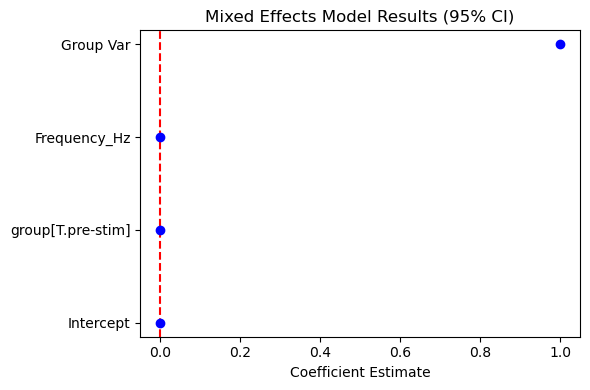

In [18]:
coefs = result.params
conf = result.conf_int()
conf.columns = ["ci_lower", "ci_upper"]

# Create a forest plot
plt.figure(figsize=(6, 4))

# We'll display coefficients in descending order so the Intercept is at the top
sorted_indices = np.arange(len(coefs))

# Plot each coefficient with its confidence interval
plt.errorbar(
    coefs[sorted_indices],
    sorted_indices,
    xerr=[
        coefs[sorted_indices] - conf["ci_lower"][sorted_indices],
        conf["ci_upper"][sorted_indices] - coefs[sorted_indices]
    ],
    fmt='o',
    color='blue',
    ecolor='black',
    capsize=3
)

# Reference line at 0
plt.axvline(x=0, color='red', linestyle='--')

# Label the y-axis ticks with coefficient names
plt.yticks(sorted_indices, coefs.index[sorted_indices])

plt.xlabel("Coefficient Estimate")
plt.title("Mixed Effects Model Results (95% CI)")
plt.tight_layout()
plt.show()


considerable uncertainty in the variance estimate

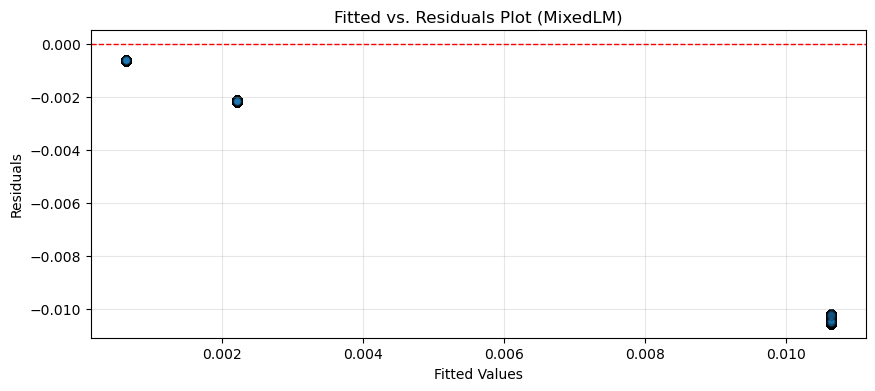

In [19]:
# 1. Obtain fitted values (predictions) from the model
fitted_vals = result.predict(df)

# 2. Compute residuals: actual - fitted
residuals = df["firing_rate_vs_stim"] - fitted_vals

# 3. Create a scatter plot of fitted vs. residuals
plt.figure(figsize=(10, 4))
plt.scatter(fitted_vals, residuals, alpha=0.2, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs. Residuals Plot (MixedLM)")
plt.grid(alpha=0.3)
# plt.tight_layout()
plt.show()


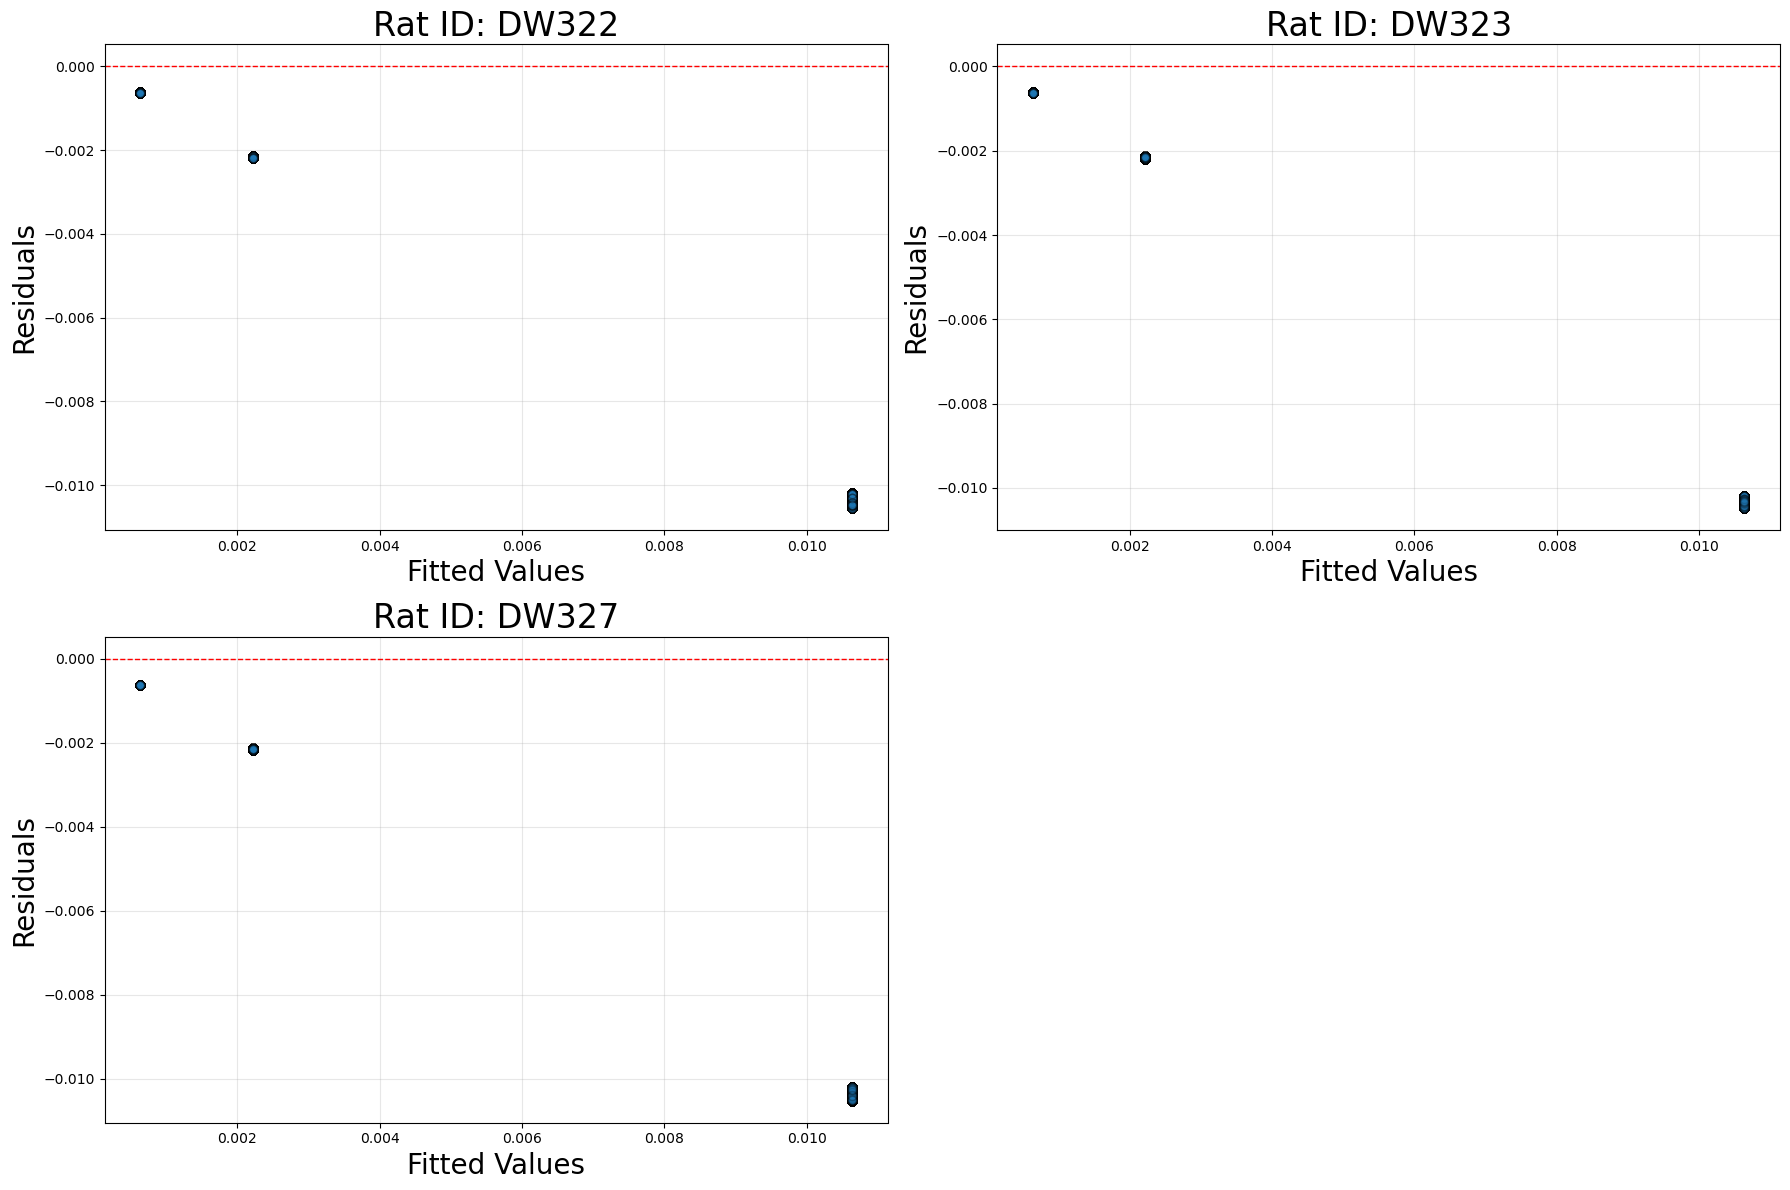

In [20]:
# 1. Compute fitted values and residuals for all observations
df["fitted_vals"] = result.predict(df)
df["residuals"] = df["firing_rate_vs_stim"] - df["fitted_vals"]

# 2. Get unique Rat IDs
unique_rats = df["Rat_ID"].unique()

# 3. Decide on subplot grid layout
n = len(unique_rats)
ncols = 2  # adjust as needed
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows))
axes = np.ravel(axes)  # Flatten in case we have multiple rows

# 4. Loop over each Rat ID and plot fitted vs. residuals
for i, rat_id in enumerate(unique_rats):
    subset = df[df["Rat_ID"] == rat_id]
    
    axes[i].scatter(
        subset["fitted_vals"], 
        subset["residuals"], 
        alpha=0.3,
        edgecolor='k'
    )
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[i].set_xlabel("Fitted Values")
    axes[i].set_ylabel("Residuals")
    axes[i].set_title(f"Rat ID: {rat_id}")
    axes[i].grid(alpha=0.3)
    axes[i].set_xlabel("Fitted Values", fontsize=20)
    axes[i].set_ylabel("Residuals", fontsize=20)
    axes[i].set_title(f"Rat ID: {rat_id}", fontsize=24)

# If there are unused subplots (e.g., if # rats is odd), hide them
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


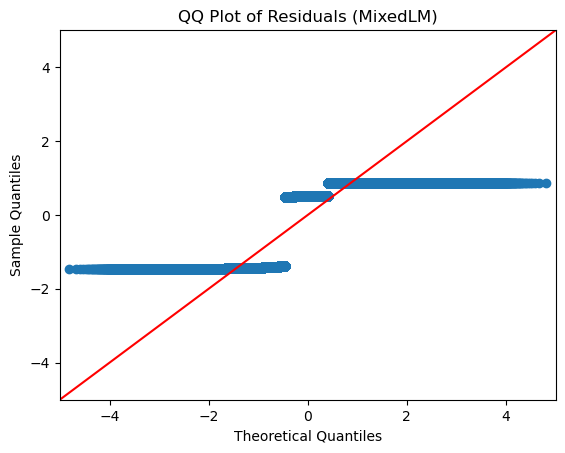

In [21]:
# 1. If you haven't already, compute fitted values and residuals
df["fitted_vals"] = result.predict(df)
df["residuals"] = df["firing_rate_vs_stim"] - df["fitted_vals"]

# 2. Create a QQ plot of the residuals
fig = sm.qqplot(df["residuals"], line='45', fit=True)
plt.title("QQ Plot of Residuals (MixedLM)")
plt.show()


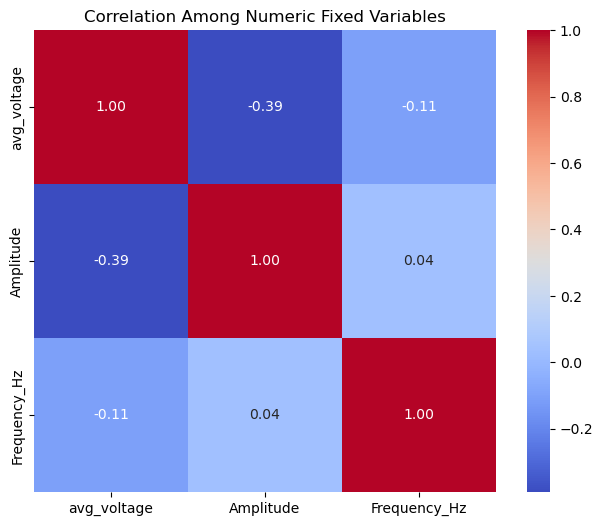

In [22]:

# Subset only the numeric columns
num_cols = ["avg_voltage", "Amplitude", "Frequency_Hz"]

# Create a correlation matrix
corr_matrix = df[num_cols].corr()

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Among Numeric Fixed Variables")
plt.show()


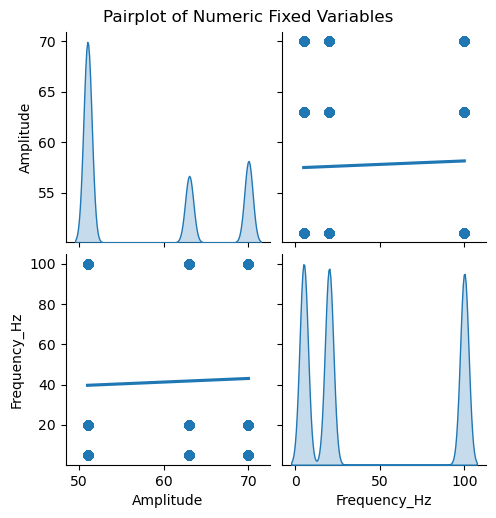

In [23]:
num_cols = ["Amplitude", "Frequency_Hz"]

sns.pairplot(df[num_cols], kind="reg", diag_kind="kde")
plt.suptitle("Pairplot of Numeric Fixed Variables", y=1.02)
plt.show()


C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\762632974.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\762632974.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\762632974.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


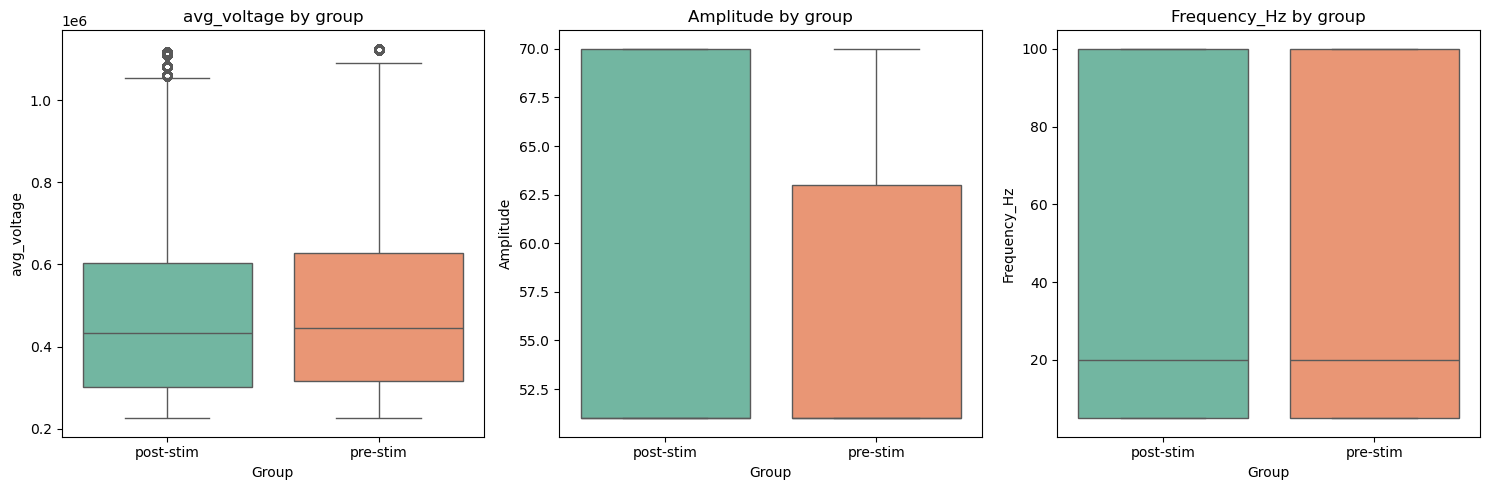

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # One row, three columns

for ax, col in zip(axes, ["avg_voltage", "Amplitude", "Frequency_Hz"]):
    sns.boxplot(
        x="group", 
        y=col, 
        data=df, 
        ax=ax,
        palette="Set2"
    )
    ax.set_title(f"{col} by group")
    ax.set_xlabel("Group")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

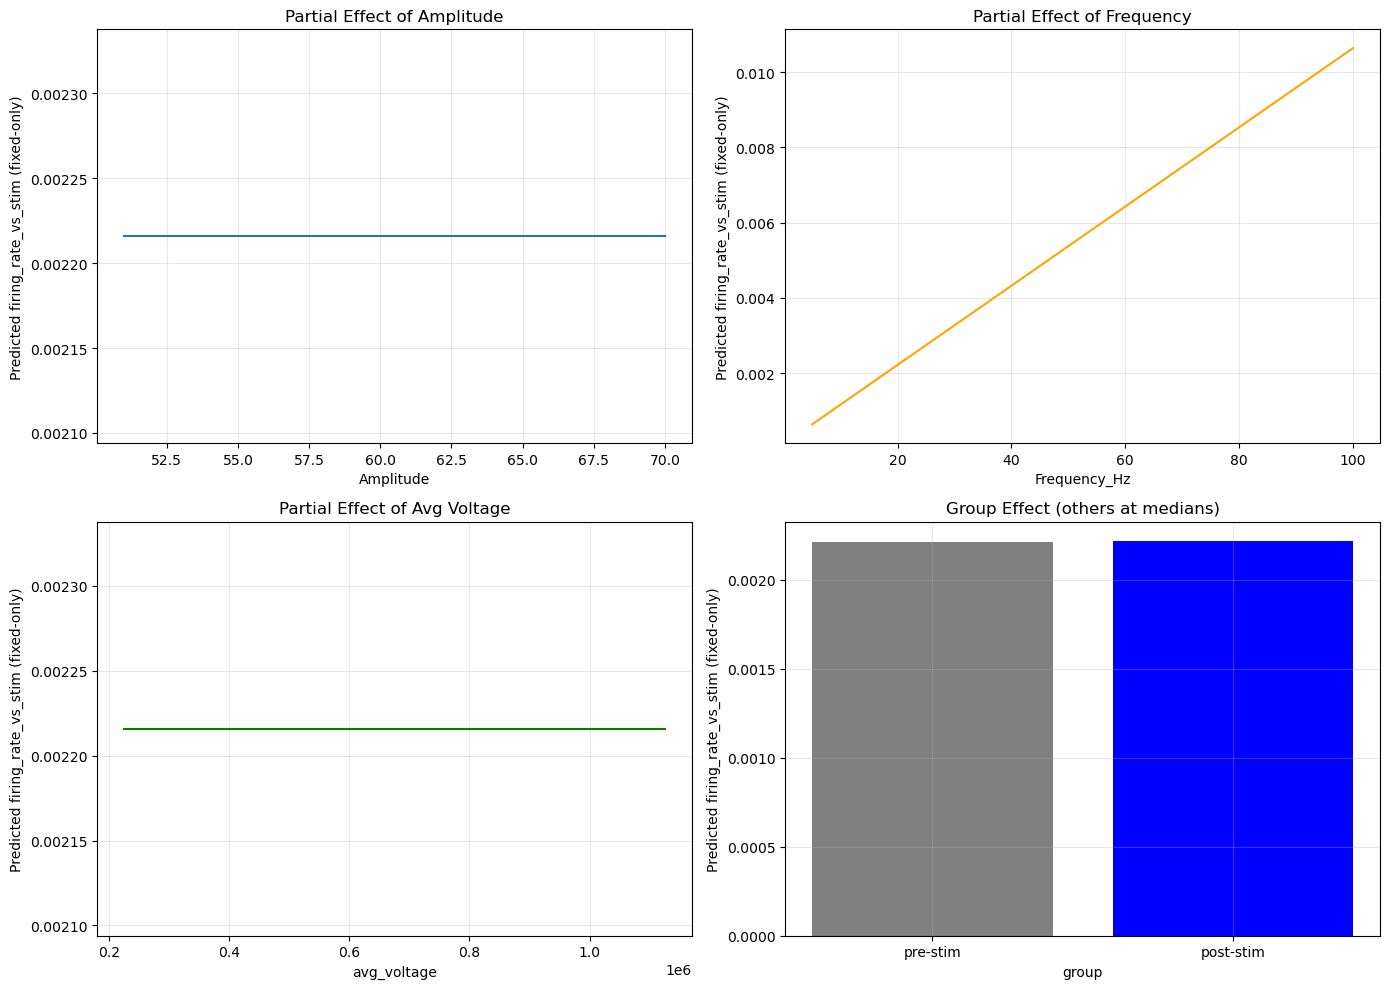

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from patsy import dmatrix

# We'll assume your model object is called `result` and your original data is in `df`.

# 1. Prepare data for partial effect plots

# We'll use median values of other variables as "typical"
amp_med = df["Amplitude"].median()
freq_med = df["Frequency_Hz"].median()
volt_med = df["avg_voltage"].median()

# We'll pick "post-stim" as the baseline group
group_baseline = "post-stim"

# 2. Generate a range of values for each variable
amp_range = np.linspace(df["Amplitude"].min(), df["Amplitude"].max(), 50)
freq_range = np.linspace(df["Frequency_Hz"].min(), df["Frequency_Hz"].max(), 50)
volt_range = np.linspace(df["avg_voltage"].min(), df["avg_voltage"].max(), 50)

# 3. For each variable, build new data frames while holding others at typical values.
#    Then create a Patsy design matrix and multiply by the fixed effects.

def predict_fixed_only(model, new_data):
    """
    Build a design matrix from 'model's formula and
    multiply by the fixed-effect parameters to get predictions
    with NO random effect added.
    """
    # The model stores the formula info in: model.model.data.design_info
    design_info = model.model.data.design_info

    # Build the design (exog) matrix for new_data
    X_new = dmatrix(design_info, new_data, return_type='dataframe')

    # Multiply by the fixed-effect parameters
    return np.dot(X_new, model.fe_params)

# 3A) Amplitude
df_amp = pd.DataFrame({
    "avg_voltage": [volt_med]*len(amp_range),
    "Amplitude": amp_range,
    "Frequency_Hz": [freq_med]*len(amp_range),
    "group": [group_baseline]*len(amp_range)
})
df_amp["pred"] = predict_fixed_only(result, df_amp)

# 3B) Frequency
df_freq = pd.DataFrame({
    "avg_voltage": [volt_med]*len(freq_range),
    "Amplitude": [amp_med]*len(freq_range),
    "Frequency_Hz": freq_range,
    "group": [group_baseline]*len(freq_range)
})
df_freq["pred"] = predict_fixed_only(result, df_freq)

# 3C) Avg Voltage
df_volt = pd.DataFrame({
    "avg_voltage": volt_range,
    "Amplitude": [amp_med]*len(volt_range),
    "Frequency_Hz": [freq_med]*len(volt_range),
    "group": [group_baseline]*len(volt_range)
})
df_volt["pred"] = predict_fixed_only(result, df_volt)

# 3D) Group categories
groups_unique = df["group"].unique()
df_group = pd.DataFrame({
    "avg_voltage": [volt_med]*len(groups_unique),
    "Amplitude": [amp_med]*len(groups_unique),
    "Frequency_Hz": [freq_med]*len(groups_unique),
    "group": groups_unique
})
df_group["pred"] = predict_fixed_only(result, df_group)

# 4. Plot partial effects in subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax_amp, ax_freq), (ax_volt, ax_group) = axes

# A) Amplitude
ax_amp.plot(df_amp["Amplitude"], df_amp["pred"], label="Predicted")
ax_amp.set_xlabel("Amplitude")
ax_amp.set_ylabel("Predicted firing_rate_vs_stim (fixed-only)")
ax_amp.set_title("Partial Effect of Amplitude")
ax_amp.grid(alpha=0.3)

# B) Frequency
ax_freq.plot(df_freq["Frequency_Hz"], df_freq["pred"], label="Predicted", color="orange")
ax_freq.set_xlabel("Frequency_Hz")
ax_freq.set_ylabel("Predicted firing_rate_vs_stim (fixed-only)")
ax_freq.set_title("Partial Effect of Frequency")
ax_freq.grid(alpha=0.3)

# C) Avg Voltage
ax_volt.plot(df_volt["avg_voltage"], df_volt["pred"], label="Predicted", color="green")
ax_volt.set_xlabel("avg_voltage")
ax_volt.set_ylabel("Predicted firing_rate_vs_stim (fixed-only)")
ax_volt.set_title("Partial Effect of Avg Voltage")
ax_volt.grid(alpha=0.3)

# D) Group categories
ax_group.bar(
    df_group["group"].astype(str),  # x-axis
    df_group["pred"],              # height
    color=["blue" if g == group_baseline else "gray" for g in df_group["group"]]
)
ax_group.set_xlabel("group")
ax_group.set_ylabel("Predicted firing_rate_vs_stim (fixed-only)")
ax_group.set_title("Group Effect (others at medians)")
ax_group.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs_no_var[sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs_no_var[sorted_indices] - conf_no_var["ci_lower"][sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


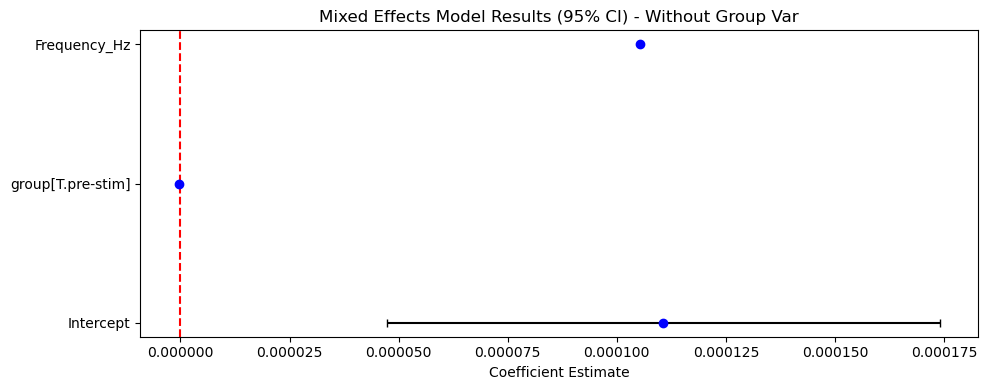

In [26]:

# 1. Drop the "Group Var" row from coefs/conf if it exists
coefs_no_var = coefs.drop(labels="Group Var", errors="ignore")
conf_no_var = conf.drop(labels="Group Var", errors="ignore")

# 2. Create a forest plot with the remaining parameters
plt.figure(figsize=(10, 4))

# Sort them if you’d like the Intercept at the top
sorted_indices = np.arange(len(coefs_no_var))

# Plot each coefficient with its confidence interval
plt.errorbar(
    coefs_no_var[sorted_indices],
    sorted_indices,
    xerr=[
        coefs_no_var[sorted_indices] - conf_no_var["ci_lower"][sorted_indices],
        conf_no_var["ci_upper"][sorted_indices] - coefs_no_var[sorted_indices]
    ],
    fmt='o',
    color='blue',
    ecolor='black',
    capsize=3
)

# Reference line at 0
plt.axvline(x=0, color='red', linestyle='--')

# Label the y-axis ticks with coefficient names
plt.yticks(sorted_indices, coefs_no_var.index[sorted_indices])

plt.xlabel("Coefficient Estimate")
plt.title("Mixed Effects Model Results (95% CI) - Without Group Var")
plt.tight_layout()

plt.show()


# 📉 linear mixed effects models - trial 2

In [27]:
# Rename the column to something without parentheses or minus signs
df = lmem_percent.copy()
df = df.dropna(subset=["Rat_ID", "percent_change"])
df = df.reset_index(drop=True)
# df = df.rename(columns={"firing_rate_vs_stim(uV^-1)": "firing_rate_vs_stim"})

# df["group"] = df["group"].cat.remove_unused_categories()

# Ensure 'group' & "Rat ID" are recognized as categorical variables
df["Rat_ID"] = df["Rat_ID"].astype("category")

# Now you can write the formula more cleanly
model = smf.mixedlm(
    formula="percent_change ~ Amplitude + Frequency_Hz",
    # formula="percent_change ~ Amplitude + Frequency_Hz",
    data=df,
    groups=df["Rat_ID"]
)

result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: percent_change
No. Observations:  618     Method:             REML          
No. Groups:        3       Scale:              203368.7235   
Min. group size:   123     Log-Likelihood:     -4647.5432    
Max. group size:   293     Converged:          Yes           
Mean group size:   206.0                                     
-------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept     240.779  400.686  0.601 0.548 -544.551 1026.109
Amplitude      -2.381    6.514 -0.366 0.715  -15.149   10.387
Frequency_Hz   -0.720    0.429 -1.679 0.093   -1.560    0.121
Group Var    6737.391   24.740                               



In [28]:
print(df.shape)
print(df["Rat_ID"].value_counts(dropna=False))

(618, 9)
Rat_ID
DW322    293
DW327    202
DW323    123
Name: count, dtype: int64


C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs[sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs[sorted_indices] - conf["ci_lower"][sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\460482866.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf["ci_upper"][sorte

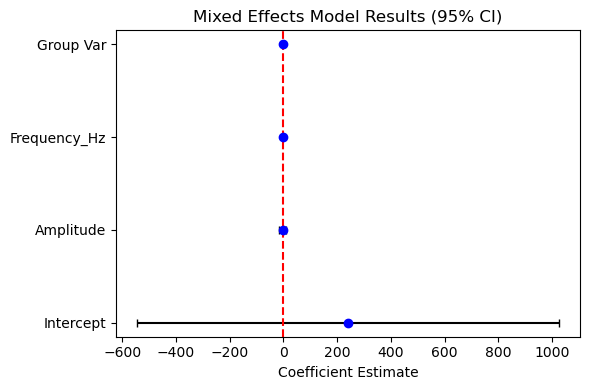

In [29]:
coefs = result.params
conf = result.conf_int()
conf.columns = ["ci_lower", "ci_upper"]

# Create a forest plot
plt.figure(figsize=(6, 4))

# We'll display coefficients in descending order so the Intercept is at the top
sorted_indices = np.arange(len(coefs))

# Plot each coefficient with its confidence interval
plt.errorbar(
    coefs[sorted_indices],
    sorted_indices,
    xerr=[
        coefs[sorted_indices] - conf["ci_lower"][sorted_indices],
        conf["ci_upper"][sorted_indices] - coefs[sorted_indices]
    ],
    fmt='o',
    color='blue',
    ecolor='black',
    capsize=3
)

# Reference line at 0
plt.axvline(x=0, color='red', linestyle='--')

# Label the y-axis ticks with coefficient names
plt.yticks(sorted_indices, coefs.index[sorted_indices])

plt.xlabel("Coefficient Estimate")
plt.title("Mixed Effects Model Results (95% CI)")
plt.tight_layout()
plt.show()


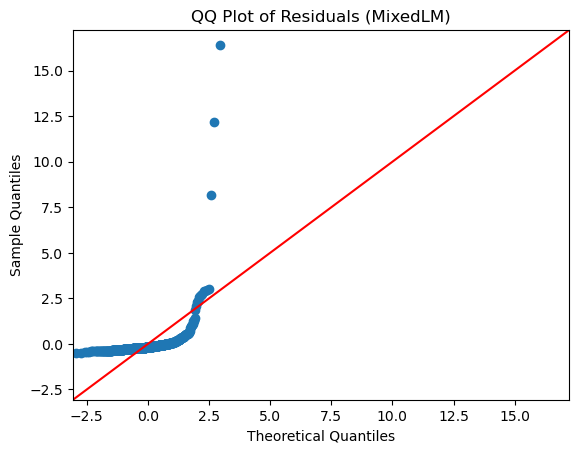

In [30]:
# 1. If you haven't already, compute fitted values and residuals
df["fitted_vals"] = result.predict(df)
df["residuals"] = df["percent_change"] - df["fitted_vals"]

# 2. Create a QQ plot of the residuals
fig = sm.qqplot(df["residuals"], line='45', fit=True)
plt.title("QQ Plot of Residuals (MixedLM)")
plt.show()


now a very normally distributed mean

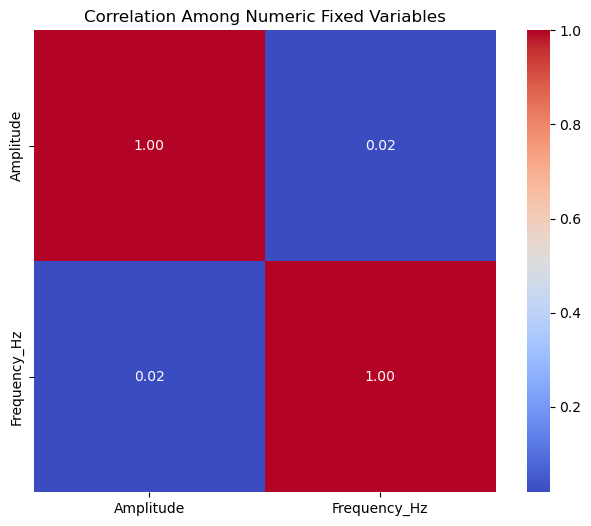

In [31]:

# Subset only the numeric columns
num_cols = [ "Amplitude", "Frequency_Hz"]

# Create a correlation matrix
corr_matrix = df[num_cols].corr()

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Among Numeric Fixed Variables")
plt.show()


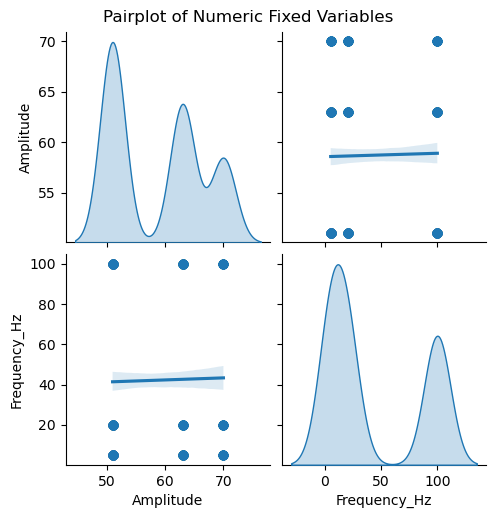

In [32]:
num_cols = ["Amplitude", "Frequency_Hz"]

sns.pairplot(df[num_cols], kind="reg", diag_kind="kde")
plt.suptitle("Pairplot of Numeric Fixed Variables", y=1.02)
plt.show()


In [33]:
df

,Trial_ID,cluster,Rat_ID,Amplitude,Frequency_Hz,Pulse_Width(us),post-stim,pre-stim,percent_change,fitted_vals,residuals
0,DW322_VF_1_240918_143256,0.0,DW322,51,5,300,0.000088,0.000047,88.229267,115.741449,-27.512182
1,DW322_VF_1_240918_143256,1.0,DW322,51,5,300,0.000039,0.000041,-3.091632,115.741449,-118.833081
2,DW322_VF_1_240918_143256,3.0,DW322,51,5,300,0.000086,0.000023,274.059750,115.741449,158.318301
3,DW322_VF_1_240918_143256,4.0,DW322,51,5,300,0.000035,0.000027,32.435144,115.741449,-83.306305
4,DW322_VF_1_240918_143256,5.0,DW322,51,5,300,0.000054,0.000031,78.316838,115.741449,-37.424611
...,...,...,...,...,...,...,...,...,...,...,...
613,DW327_VF_10_241125_162725,9.0,DW327,63,5,300,0.000052,0.000036,44.757281,87.167562,-42.410281
614,DW327_VF_10_241125_162725,10.0,DW327,63,5,300,0.000007,0.00001,-29.214959,87.167562,-116.382521
615,DW327_VF_10_241125_162725,11.0,DW327,63,5,300,0.000009,0.00003,-68.642878,87.167562,-155.810440
616,DW327_VF_10_241125_162725,12.0,DW327,63,5,300,0.000063,0.000075,-16.017833,87.167562,-103.185395


C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\3089209521.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\3089209521.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


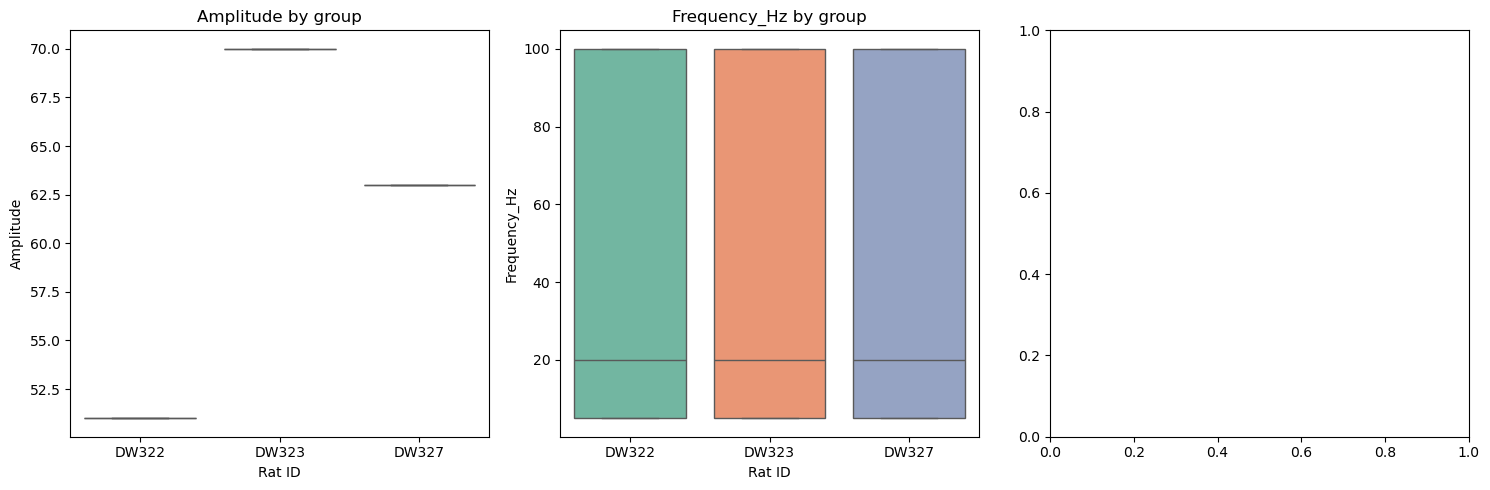

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # One row, three columns

for ax, col in zip(axes, ["Amplitude", "Frequency_Hz"]):
    sns.boxplot(
        x="Rat_ID",
        y=col, 
        data=df, 
        ax=ax,
        palette="Set2"
    )
    ax.set_title(f"{col} by group")
    ax.set_xlabel("Rat ID")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

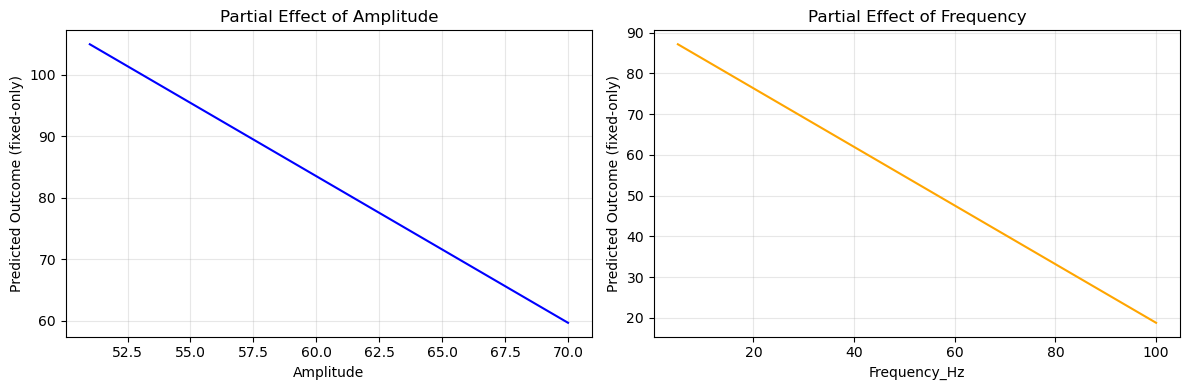

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix

def predict_fixed_only(model, new_data):
    """
    Build a design matrix from 'model's formula and
    multiply by the fixed-effect parameters to get predictions
    with NO random effect added.
    """
    design_info = model.model.data.design_info
    X_new = dmatrix(design_info, new_data, return_type='dataframe')
    return np.dot(X_new, model.fe_params)

# Example usage:
def plot_partial_effects_amplitude_frequency(model, df):
    """
    Plots partial effects for Amplitude and Frequency_Hz only,
    holding the other variable at its median.
    """

    # 1. Compute medians
    amp_med = df["Amplitude"].median()
    freq_med = df["Frequency_Hz"].median()

    # 2. Build data ranges
    amp_range = np.linspace(df["Amplitude"].min(), df["Amplitude"].max(), 50)
    freq_range = np.linspace(df["Frequency_Hz"].min(), df["Frequency_Hz"].max(), 50)

    # 3. Create DataFrame for Amplitude partial (vary amplitude, hold freq at median)
    df_amp = pd.DataFrame({
        "Amplitude": amp_range,
        "Frequency_Hz": [freq_med] * len(amp_range)
    })
    df_amp["pred"] = predict_fixed_only(model, df_amp)

    # 4. Create DataFrame for Frequency partial (vary frequency, hold amplitude at median)
    df_freq = pd.DataFrame({
        "Amplitude": [amp_med] * len(freq_range),
        "Frequency_Hz": freq_range
    })
    df_freq["pred"] = predict_fixed_only(model, df_freq)

    # 5. Make a 1x2 plot
    fig, (ax_amp, ax_freq) = plt.subplots(1, 2, figsize=(12, 4))

    # --- Amplitude subplot ---
    ax_amp.plot(df_amp["Amplitude"], df_amp["pred"], color="blue")
    ax_amp.set_xlabel("Amplitude")
    ax_amp.set_ylabel("Predicted Outcome (fixed-only)")
    ax_amp.set_title("Partial Effect of Amplitude")
    ax_amp.grid(alpha=0.3)

    # --- Frequency subplot ---
    ax_freq.plot(df_freq["Frequency_Hz"], df_freq["pred"], color="orange")
    ax_freq.set_xlabel("Frequency_Hz")
    ax_freq.set_ylabel("Predicted Outcome (fixed-only)")
    ax_freq.set_title("Partial Effect of Frequency")
    ax_freq.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# In your code, assuming `result` is your fitted model and `df` is your data:
plot_partial_effects_amplitude_frequency(result, df)


C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs_no_var[sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs_no_var[sorted_indices] - conf_no_var["ci_lower"][sorted_indices],
C:\Users\Karl\AppData\Local\Temp\ipykernel_8420\2285718480.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


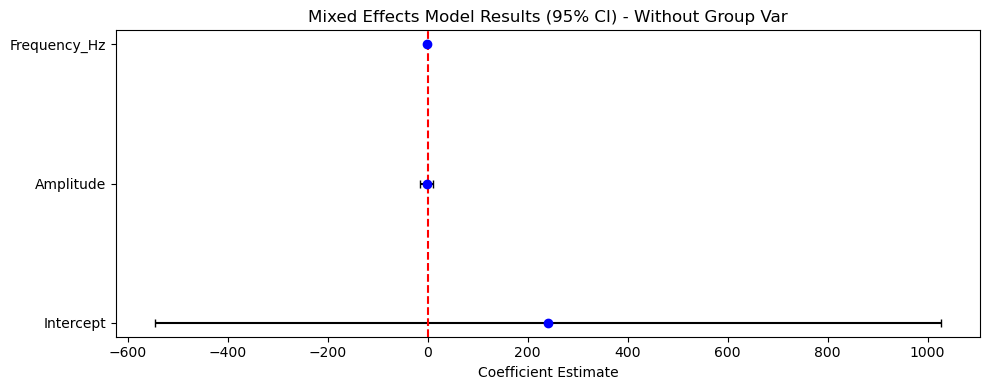

In [36]:

# 1. Drop the "Group Var" row from coefs/conf if it exists
coefs_no_var = coefs.drop(labels="Group Var", errors="ignore")
conf_no_var = conf.drop(labels="Group Var", errors="ignore")

# 2. Create a forest plot with the remaining parameters
plt.figure(figsize=(10, 4))

# Sort them if you’d like the Intercept at the top
sorted_indices = np.arange(len(coefs_no_var))

# Plot each coefficient with its confidence interval
plt.errorbar(
    coefs_no_var[sorted_indices],
    sorted_indices,
    xerr=[
        coefs_no_var[sorted_indices] - conf_no_var["ci_lower"][sorted_indices],
        conf_no_var["ci_upper"][sorted_indices] - coefs_no_var[sorted_indices]
    ],
    fmt='o',
    color='blue',
    ecolor='black',
    capsize=3
)

# Reference line at 0
plt.axvline(x=0, color='red', linestyle='--')

# Label the y-axis ticks with coefficient names
plt.yticks(sorted_indices, coefs_no_var.index[sorted_indices])

plt.xlabel("Coefficient Estimate")
plt.title("Mixed Effects Model Results (95% CI) - Without Group Var")
plt.tight_layout()

plt.show()


# 📊 linear mixed effects models - trial 3

## Full Repeated-Measures Model:
Outcome: Firing_Rate
Fixed Effects: Condition, Frequency, and their interaction
Random Effects: Random intercept (and optionally random slope for condition) by Rat_ID

The model would conceptually look like:

Firing_Rate ~ Condition * C(Frequency) + (1 [+ Condition] | Rat_ID)

## Percent Change Model:
Alternatively, if you pre-compute the percent change between pre and post for each trial, your outcome becomes a single number per trial. Then, you would model:

Percent_Change ~ C(Frequency) + (1 | Rat_ID)

This approach is simpler but loses the full pre vs. post modeling because the change is already aggregated.

In [37]:
import pandas as pd
import statsmodels.formula.api as smf


# Assume df is your original DataFrame.
df = lmem_percent.copy()

# Convert from wide format (with 'pre-stim' and 'post-stim') to long format.
df_long = pd.melt(
    df,
    id_vars=["Trial_ID", "cluster", "Rat_ID", "Amplitude", "Frequency_Hz", "Pulse_Width(us)"],
    value_vars=["pre-stim", "post-stim"],
    var_name="Condition",
    value_name="Firing_Rate"
)

# Convert to categorical
df_long["Condition"] = df_long["Condition"].astype("category")
df_long["Frequency_Hz"] = df_long["Frequency_Hz"].astype("category")
df_long["Rat_ID"] = df_long["Rat_ID"].astype("category")

# convert to numeric
df_long['Firing_Rate'] = pd.to_numeric(df_long['Firing_Rate'], errors='coerce')
# Optionally, drop any rows where conversion failed
df_long = df_long.dropna(subset=['Firing_Rate'])

# View the reshaped data
print(df_long.head())


                   Trial_ID  cluster Rat_ID  Amplitude Frequency_Hz  \
0  DW322_VF_1_240918_143256      0.0  DW322         51            5   
1  DW322_VF_1_240918_143256      1.0  DW322         51            5   
2  DW322_VF_1_240918_143256      3.0  DW322         51            5   
3  DW322_VF_1_240918_143256      4.0  DW322         51            5   
4  DW322_VF_1_240918_143256      5.0  DW322         51            5   

   Pulse_Width(us) Condition  Firing_Rate  
0              300  pre-stim     0.000047  
1              300  pre-stim     0.000041  
2              300  pre-stim     0.000023  
3              300  pre-stim     0.000027  
4              300  pre-stim     0.000031  


In [38]:

import pandas as pd
import statsmodels.formula.api as smf

# Create a unique identifier for each cluster within each trial
df['Trial_Cluster'] = df['Trial_ID'] + "_" + df['cluster'].astype(str)

# Convert categorical variables
df["Rat_ID"] = df["Rat_ID"].astype("category")
df["Trial_ID"] = df["Trial_ID"].astype("category")
df["Frequency_Hz"] = df["Frequency_Hz"].astype("category")

# Suppose you work with the long-format data (with a 'Condition' and 'Firing_Rate')
# Otherwise, if modeling percent_change (aggregated per cluster/trial), adjust accordingly.

# For example, if you’re modeling raw firing rates in a long format:
model = smf.mixedlm(
    formula="Firing_Rate ~ Condition * Frequency_Hz",
    data=df_long,  # your long-format data
    groups=df_long["Rat_ID"],
    re_formula="~Condition"  # optionally add random slopes for Condition
)
result = model.fit()
print(result.summary())



c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Firing_Rate
No. Observations:          1264             Method:                      REML       
No. Groups:                3                Scale:                       0.0000     
Min. group size:           260              Log-Likelihood:              11012.6815 
Max. group size:           586              Converged:                   Yes        
Mean group size:           421.3                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.000    0.000  4.555 0.000  0.000  0.000
Condition[T.pre-stim]                      0.000    0.000  0.035 0.972 -0.000  0.000
Freq

c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# 📈 trial 4 - nested cluster, trial, rat id

MAKE SURE TO DO THIS STEP


when you filter by correlation threshhold, it is going to drop rows and some of the data may refer to old indices.  This can happen if you drop rows (for example, due to missing percent_change values) without resetting the index, so some groups still reference old index values.



this graph is hard to draw any conclusions from - plot the average trend, with std error bars

#### structure of dataset

* Rat
    * trial 
        * cluster ID

#### Predictor/Fixed Variable:
* Frequency_Hz (categorical: 5, 20, 100 Hz): frequency of DRG stimulation
#### Random Effects:
* Rat_ID: Differences in baseline firing changes between animals.
* Trial_ID (nested within Rat_ID): Trial‐to‐trial variability (per animal).
* Trial_Cluster: Variability at the neuron level (per trial).

**Model Formula:**

$$
\text{percent\_change\_reactivity} \sim \text{Frequency\_Hz} + (1 \mid \text{Rat\_ID}) + \{ \text{Trial}: 0 + C(\text{Trial\_ID}),\ \text{Neuron}: 0 + C(\text{Trial\_Cluster}) \}
$$


#### methods

In [39]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_percent_change(lmem_percent, lower_bound, upper_bound):
    """
    Analyze and plot percent change in firing rate based on specified bounds.
    
    Parameters:
        lmem_percent (pd.DataFrame): DataFrame containing columns:
            - 'Trial_ID', 'cluster', 'Rat_ID', 'Amplitude',
              'Frequency_Hz', 'Pulse_Width(us)', 'post_stim',
              'pre_stim', 'percent_change'
        lower_bound (numeric): Lower bound for percent_change filter.
        upper_bound (numeric): Upper bound for percent_change filter.
        
    Returns:
        result: Fitted mixed effects model result.
        filtered_df: The filtered and cleaned DataFrame.
        agg_df: Aggregated DataFrame used for plotting average trends.
    """
    # Filter rows by percent_change bounds
    filtered = lmem_percent[
        (lmem_percent["percent_change"] >= lower_bound) &
        (lmem_percent["percent_change"] <= upper_bound)
    ].copy()
    
    # Ensure percent_change is numeric and drop missing rows, then reset index
    filtered['percent_change'] = pd.to_numeric(filtered['percent_change'], errors='coerce')
    filtered = filtered.dropna(subset=['percent_change']).reset_index(drop=True)
    
    # Create a unique identifier for each neuron (cluster) within each trial
    filtered['Trial_Cluster'] = filtered['Trial_ID'].astype(str) + "_" + filtered['cluster'].astype(str)
    
    # Convert relevant columns to categorical and remove unused categories
    filtered["Rat_ID"] = filtered["Rat_ID"].astype("category").cat.remove_unused_categories()
    filtered["Trial_ID"] = filtered["Trial_ID"].astype("category").cat.remove_unused_categories()
    filtered["Frequency_Hz"] = filtered["Frequency_Hz"].astype("category").cat.remove_unused_categories()
    filtered["Trial_Cluster"] = filtered["Trial_Cluster"].astype("category").cat.remove_unused_categories()
    
    # --- Fit the mixed effects model with nested variance components ---
    model = smf.mixedlm(
        formula="percent_change ~ Frequency_Hz",
        data=filtered,
        groups=filtered["Rat_ID"],
        vc_formula={
            "Trial": "0 + C(Trial_ID)",
            "Neuron": "0 + C(Trial_Cluster)"
        }
    )
    result = model.fit() # print the model results at the end, so it's easier to read them in the notebook
    
    # --- Plot 1: Raw Data Line Plot by Rat ---
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        x="Frequency_Hz",
        y="percent_change",
        hue="Rat_ID",
        data=filtered,
        marker="o",         # markers on the data points
        estimator=None,     # plot raw values, not an average
        sort=False          # keeps frequencies in the order they appear
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("DRG Stimulation Frequency (Hz)")
    plt.ylabel("Percent Change: Firing Rate vs Noxious Stimuli,\npre vs post DRGS (Hz/uV)")
    plt.title("Percent Change in Neuron Firing Rate by Frequency and Animal ID")
    plt.legend(title="Rat ID", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # --- Aggregate data for average trend plotting ---
    agg_df = filtered.groupby(["Rat_ID", "Frequency_Hz"],observed=False)["percent_change"].agg(["mean", "std"]).reset_index()
    agg_df.rename(columns={"mean": "mean_change", "std": "std_change"}, inplace=True)
    
    # --- Plot 2: Average Trend with Error Bars ---
    unique_rats = agg_df["Rat_ID"].unique()
    palette = sns.color_palette("deep", n_colors=len(unique_rats))
    color_map = dict(zip(unique_rats, palette))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)
    
    for rat in unique_rats:
        subset = agg_df[agg_df["Rat_ID"] == rat]
        color = color_map[rat]
        ax.plot(
            subset["Frequency_Hz"],
            subset["mean_change"],
            marker='o',
            linestyle='-',
            color=color,
            label=rat
        )
        ax.errorbar(
            subset["Frequency_Hz"],
            subset["mean_change"],
            yerr=subset["std_change"],
            fmt='none',
            ecolor=color,
            capsize=3
        )
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("DRG Stimulation Frequency (Hz)")
    plt.ylabel("Mean Percent Change: Firing Rate vs Noxious Stimuli,\npre vs post DRGS (Hz/uV)")
    ax.set_title("Mean Percent Change by Frequency and Animal ID")
    ax.legend(title="Rat ID", loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # --- Plot 3: Average Trend with Shaded Standard Deviation ---
    # Convert Frequency_Hz to numeric for fill_between
    agg_df["Frequency_Hz"] = pd.to_numeric(agg_df["Frequency_Hz"])
    unique_rats = agg_df["Rat_ID"].unique()
    palette = sns.color_palette("deep", n_colors=len(unique_rats))
    color_map = dict(zip(unique_rats, palette))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)
    
    for rat in unique_rats:
        subset = agg_df[agg_df["Rat_ID"] == rat].sort_values("Frequency_Hz")
        x = subset["Frequency_Hz"]
        y = subset["mean_change"]
        yerr = subset["std_change"]
        color = color_map[rat]
        
        # Shade the area representing ± std dev
        ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.3)
        ax.plot(x, y, marker='o', linestyle='-', color=color, label=rat)
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("DRG Stimulation Frequency (Hz)")
    ax.set_ylabel("Mean Percent Change in Firing Rate")
    ax.set_title("Mean Percent Change by Frequency and Rat")
    ax.legend(title="Rat ID", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # print the results of the model at the bottom so I can take notes
    print(result.summary())
    
    return result, filtered, agg_df


#### range, -1000 % to 1000 % change

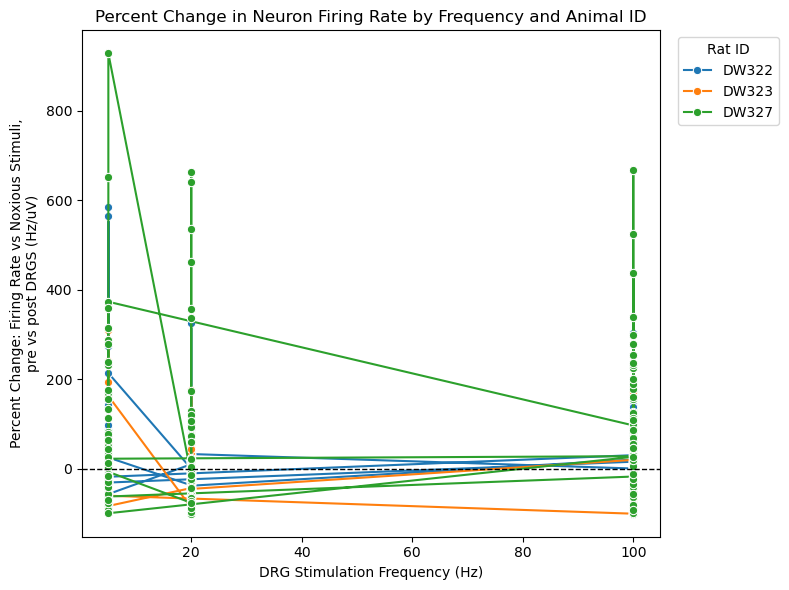

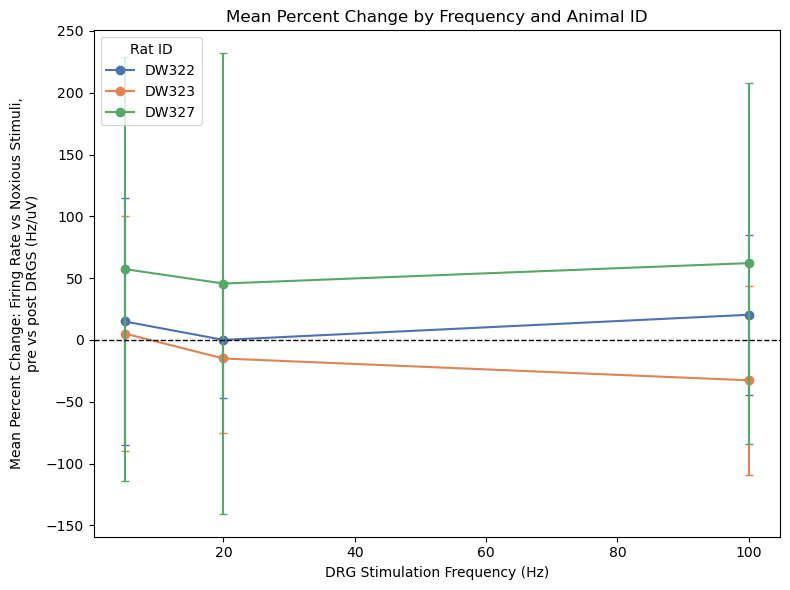

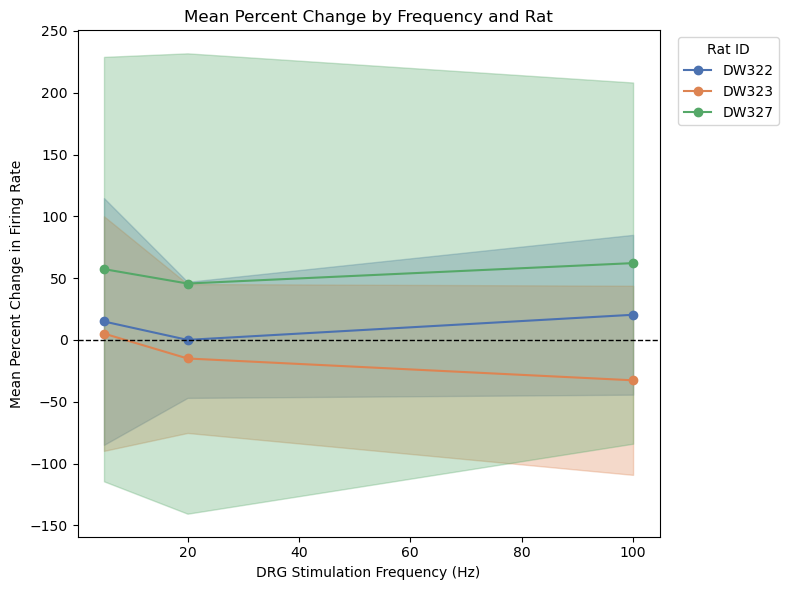

              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  percent_change
No. Observations:    603      Method:              REML          
No. Groups:          3        Scale:               4858.1566     
Min. group size:     122      Log-Likelihood:      -3694.6230    
Max. group size:     289      Converged:           Yes           
Mean group size:     201.0                                       
-----------------------------------------------------------------
                     Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept             27.183   15.205  1.788 0.074  -2.618 56.985
Frequency_Hz[T.20]   -18.097   22.729 -0.796 0.426 -62.645 26.452
Frequency_Hz[T.100]    1.155   21.475  0.054 0.957 -40.936 43.246
Neuron Var          7243.661                                     
Trial Var           1516.632                                     



In [40]:
result, filtered_df, aggregated_df = analyze_percent_change(lmem_percent, lower_bound=-1000, upper_bound=1000)

* statistically significant increase in firing activity at 5Hz 
* decrease in firing activity at 100Hz and 5Hz, but these are statistically insignificant
* the largest variance is in the Neuron level

#### look at all neurons

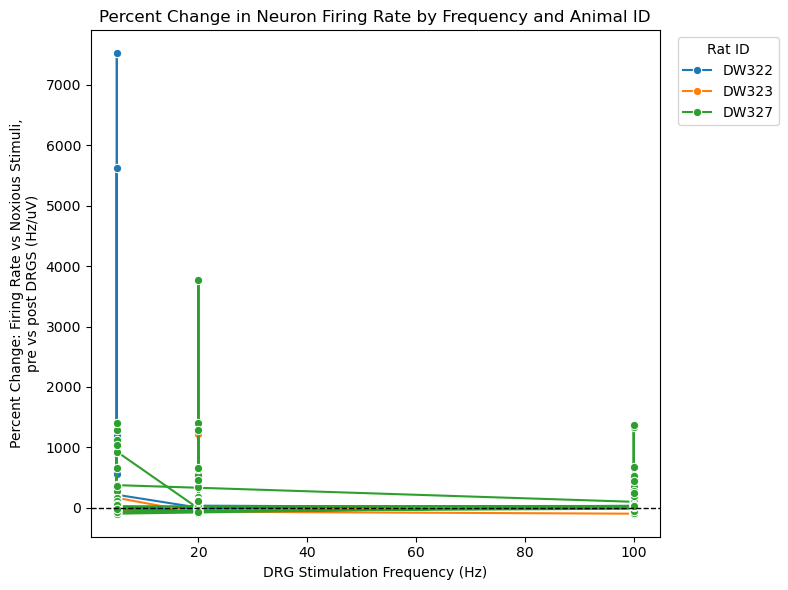

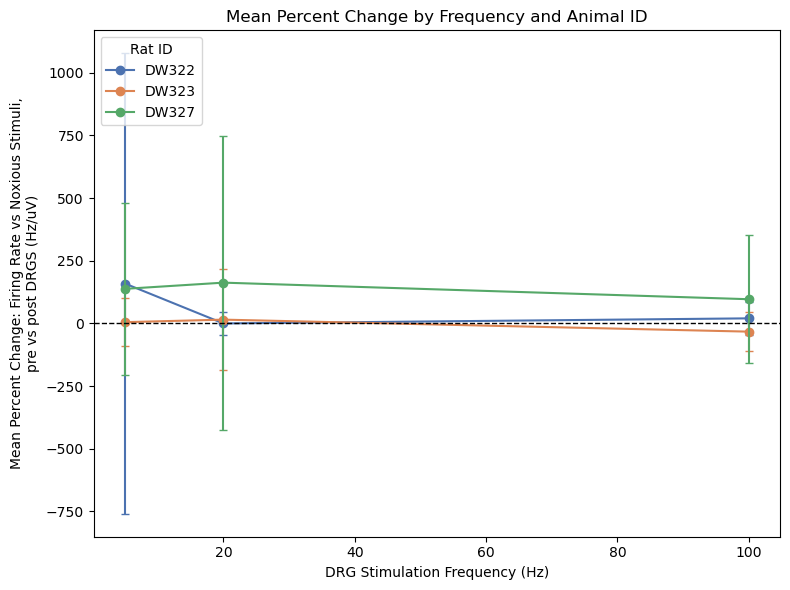

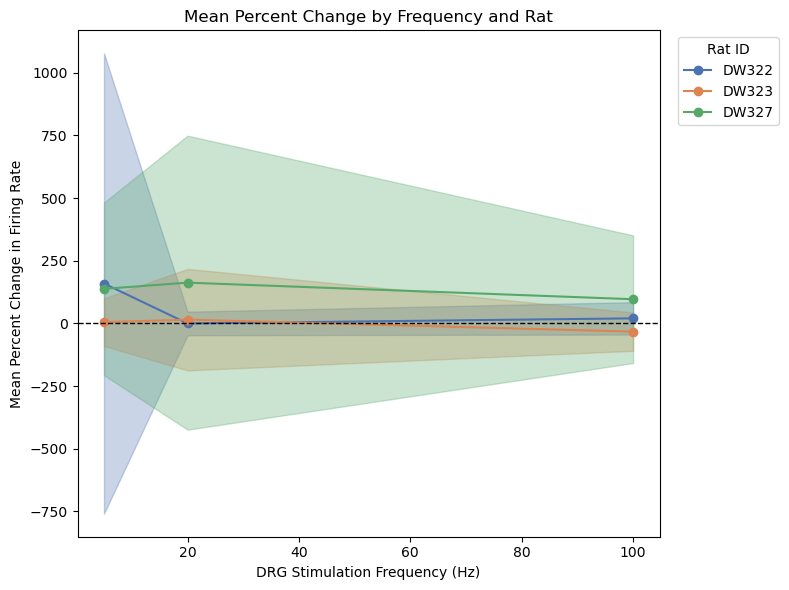

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    percent_change
No. Observations:    618        Method:                REML          
No. Groups:          3          Scale:                 67683.2613    
Min. group size:     123        Log-Likelihood:        -4640.8645    
Max. group size:     293        Converged:             Yes           
Mean group size:     206.0                                           
---------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------
Intercept              120.813   33.868  3.567 0.000   54.433 187.192
Frequency_Hz[T.20]     -69.627   50.232 -1.386 0.166 -168.080  28.826
Frequency_Hz[T.100]    -82.427   48.199 -1.710 0.087 -176.896  12.042
Neuron Var          135358.072                                       
Trial Var             1871.426      

In [41]:
result, filtered_df, aggregated_df = analyze_percent_change(lmem_percent, lower_bound=-100000, upper_bound=100000)

#### isolate the attenutated neurons

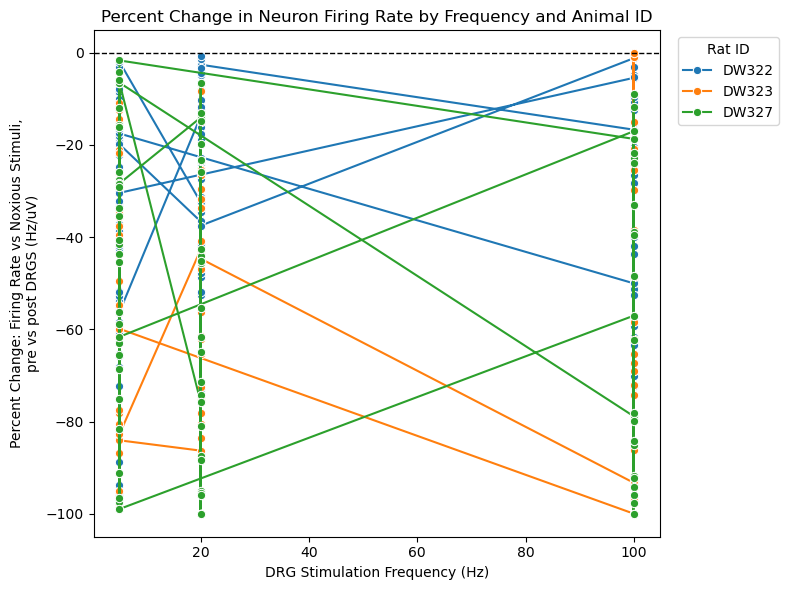

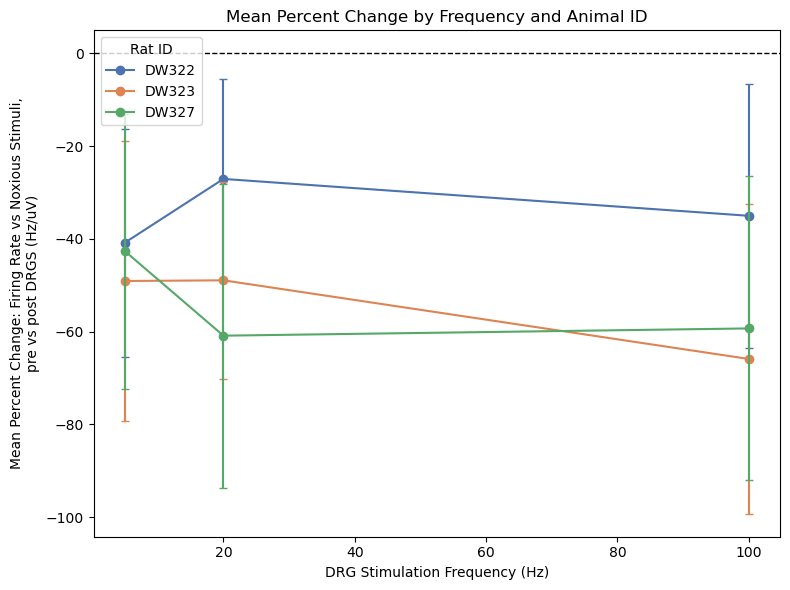

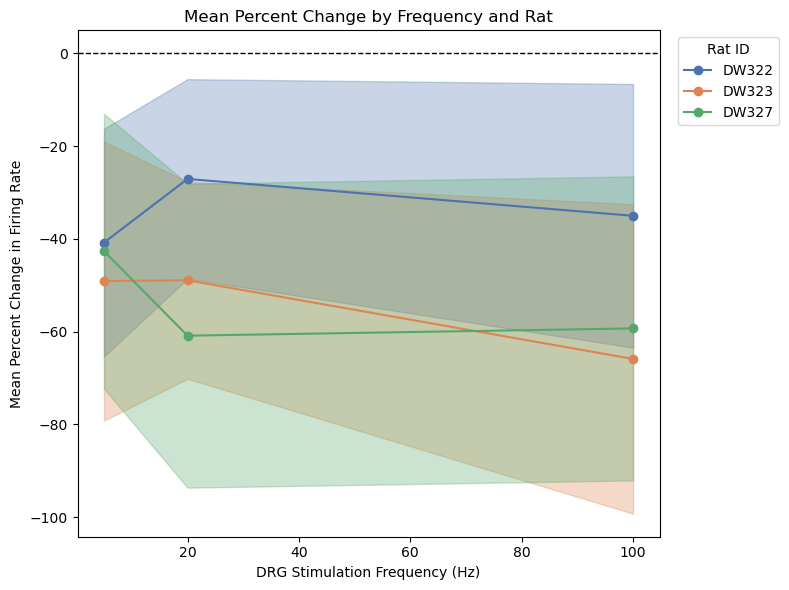

              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  percent_change
No. Observations:    301      Method:              REML          
No. Groups:          3        Scale:               327.9242      
Min. group size:     83       Log-Likelihood:      -1430.1538    
Max. group size:     131      Converged:           Yes           
Mean group size:     100.3                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           -42.360    5.216 -8.122 0.000 -52.582 -32.137
Frequency_Hz[T.20]   -0.625    7.717 -0.081 0.935 -15.751  14.500
Frequency_Hz[T.100]  -8.093    7.524 -1.076 0.282 -22.839   6.654
Neuron Var          422.679                                      
Trial Var           173.450                                      



In [42]:
result, filtered_df, aggregated_df = analyze_percent_change(lmem_percent, lower_bound=-100000, upper_bound=0)

#### isolate the activated neurons

c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

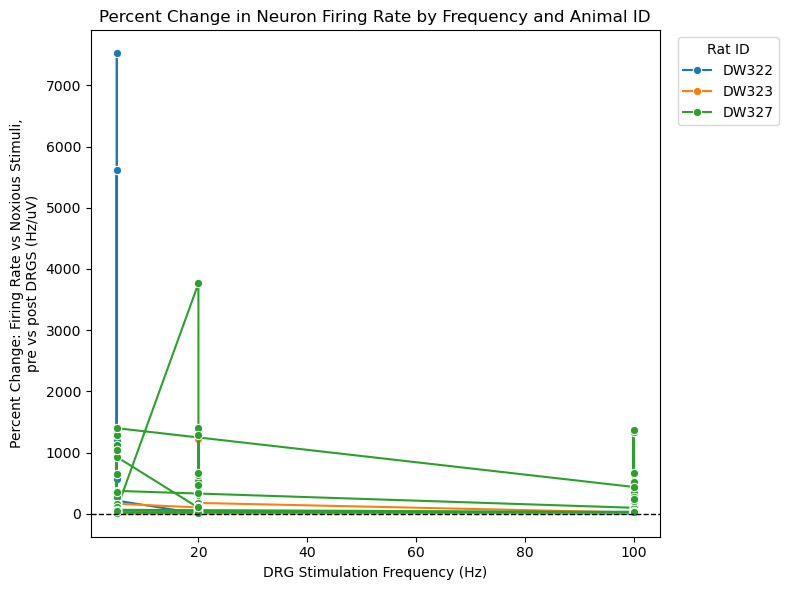

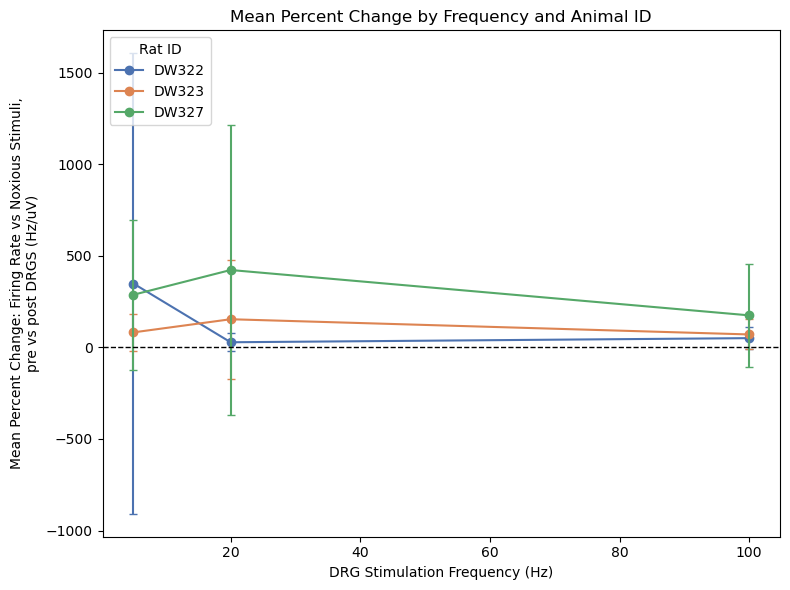

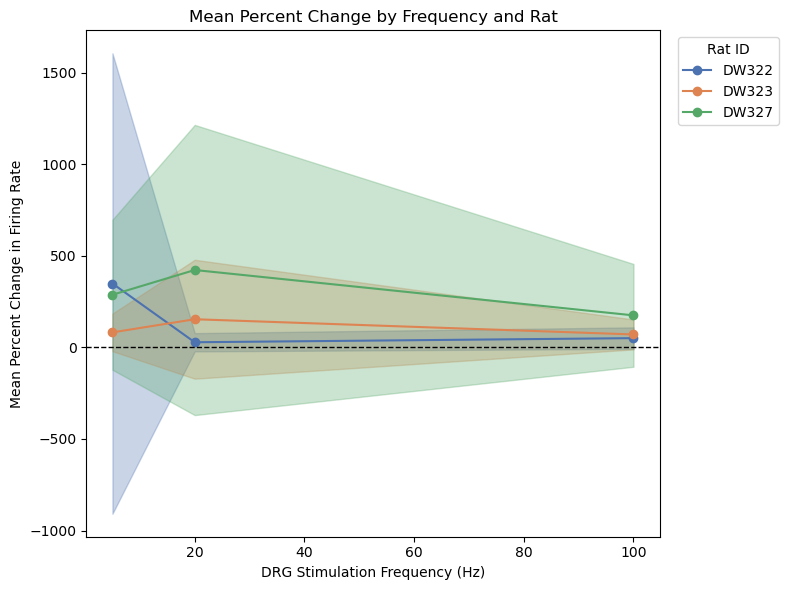

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    percent_change
No. Observations:    317        Method:                REML          
No. Groups:          3          Scale:                 109880.7996   
Min. group size:     40         Log-Likelihood:        -2465.7489    
Max. group size:     162        Converged:             No            
Mean group size:     105.7                                           
---------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------
Intercept              284.947   58.303  4.887 0.000  170.676 399.219
Frequency_Hz[T.20]    -116.731   89.553 -1.303 0.192 -292.251  58.789
Frequency_Hz[T.100]   -182.094   80.625 -2.259 0.024 -340.115 -24.073
Neuron Var          260248.291                                       
Trial Var              667.837      

In [43]:
result, filtered_df, aggregated_df = analyze_percent_change(lmem_percent, lower_bound=0, upper_bound=100000)

#### redefine neural activity as "reactivity"


**Reactivity Definition:**

The **reactivity** is defined as the average firing rate in response to the stimulus.

---

**Reactivity Formula:**

$$
\text{Reactivity} = \frac{\text{Neuron Firing Rate (Hz)}}{\text{Noxious Stimuli (}\mu\text{V)}}
$$


**Percent Change Reactivity Calculation:**

$$
\text{Percent Change Reactivity} = 100 \times \frac{\text{post-stim} - \text{pre-stim}}{\lvert \text{pre-stim} \rvert}
$$


**Model Formula:**

$$
\text{percent\_change\_reactivity} \sim \text{Frequency\_Hz} + (1 \mid \text{Rat\_ID}) + \{ \text{Trial}: 0 + C(\text{Trial\_ID}),\ \text{Neuron}: 0 + C(\text{Trial\_Cluster}) \}
$$


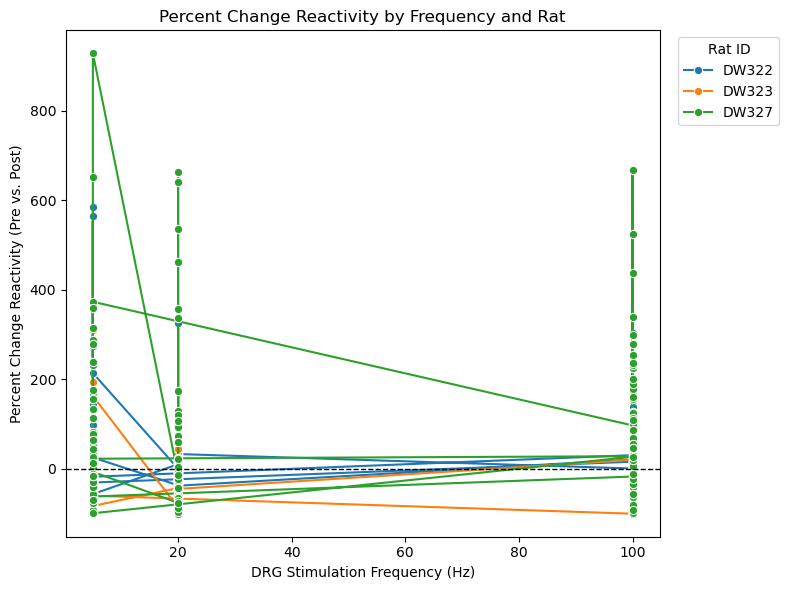

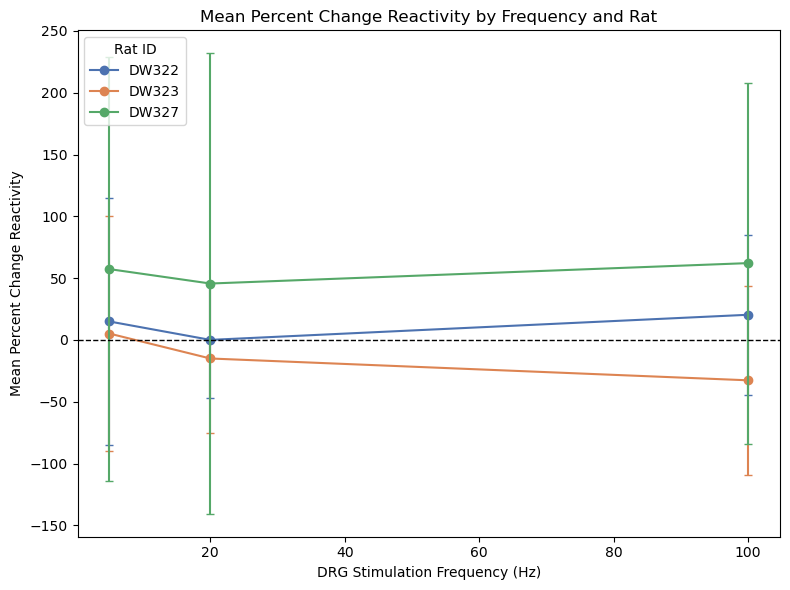

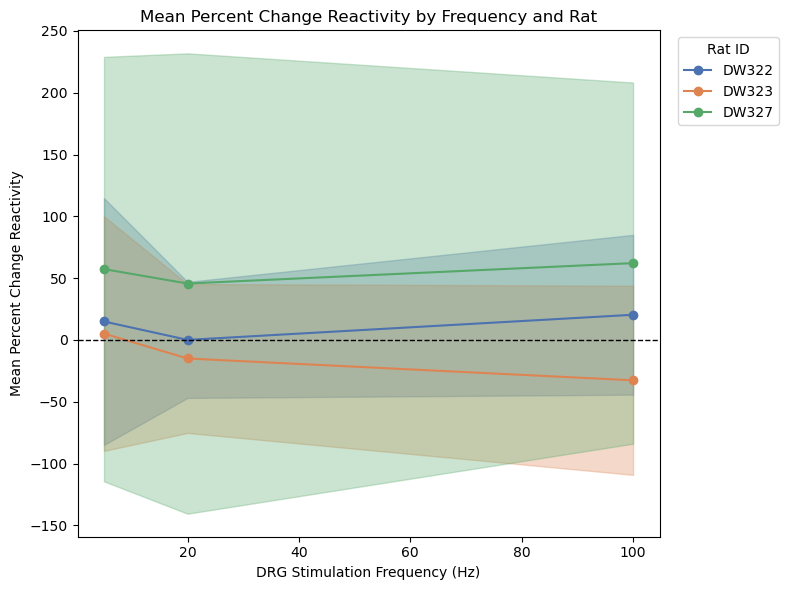

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_change_reactivity
No. Observations: 603     Method:             REML                     
No. Groups:       3       Scale:              4858.1566                
Min. group size:  122     Log-Likelihood:     -3694.6230               
Max. group size:  289     Converged:          Yes                      
Mean group size:  201.0                                                
------------------------------------------------------------------------
                       Coef.    Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               27.183    15.205   1.788  0.074   -2.618  56.985
Frequency_Hz[T.20]     -18.097    22.729  -0.796  0.426  -62.645  26.452
Frequency_Hz[T.100]      1.155    21.475   0.054  0.957  -40.936  43.246
Neuron Var            7243.661                                          
Tr

In [44]:
def analyze_percent_change_reactivity(lmem_percent, lower_bound, upper_bound):
    """
    Analyze and plot percent change in reactivity (average firing rate vs stimuli)
    defined as:
    
        percent_change_reactivity = 100 * (post-stim - pre-stim) / |pre-stim|
    
    for each neuron (cluster) across trials and rats.
    
    Parameters:
        lmem_percent (pd.DataFrame): DataFrame containing columns:
            - 'Trial_ID', 'cluster', 'Rat_ID', 'Amplitude',
              'Frequency_Hz', 'Pulse_Width(us)', 'post-stim', 'pre-stim'
        lower_bound (numeric): Lower bound for filtering percent_change_reactivity.
        upper_bound (numeric): Upper bound for filtering percent_change_reactivity.
        
    Returns:
        result: Fitted mixed effects model result.
        filtered (pd.DataFrame): The filtered and cleaned DataFrame.
        agg_df (pd.DataFrame): Aggregated DataFrame used for plotting average trends.
    """
    # Compute percent change reactivity using raw values
    def compute_pct_change(row):
        if row["pre-stim"] == 0:
            return np.nan
        return 100 * (row["post-stim"] - row["pre-stim"]) / abs(row["pre-stim"])
    
    lmem_percent["percent_change_reactivity"] = lmem_percent.apply(compute_pct_change, axis=1)
    
    # Filter rows based on the computed percent change reactivity bounds
    filtered = lmem_percent[
        (lmem_percent["percent_change_reactivity"] >= lower_bound) &
        (lmem_percent["percent_change_reactivity"] <= upper_bound)
    ].copy()
    
    # Ensure percent_change_reactivity is numeric and drop missing rows, then reset index
    filtered["percent_change_reactivity"] = pd.to_numeric(filtered["percent_change_reactivity"], errors="coerce")
    filtered = filtered.dropna(subset=["percent_change_reactivity"]).reset_index(drop=True)
    
    # Create a unique identifier for each neuron (cluster) within each trial
    filtered["Trial_Cluster"] = filtered["Trial_ID"].astype(str) + "_" + filtered["cluster"].astype(str)
    
    # Convert relevant columns to categorical and remove unused categories
    filtered["Rat_ID"] = filtered["Rat_ID"].astype("category").cat.remove_unused_categories()
    filtered["Trial_ID"] = filtered["Trial_ID"].astype("category").cat.remove_unused_categories()
    filtered["Frequency_Hz"] = filtered["Frequency_Hz"].astype("category").cat.remove_unused_categories()
    filtered["Trial_Cluster"] = filtered["Trial_Cluster"].astype("category").cat.remove_unused_categories()
    
    # --- Fit the mixed effects model with nested variance components ---
    model = smf.mixedlm(
        formula="percent_change_reactivity ~ Frequency_Hz",
        data=filtered,
        groups=filtered["Rat_ID"],
        vc_formula={
            "Trial": "0 + C(Trial_ID)",
            "Neuron": "0 + C(Trial_Cluster)"
        }
    )
    result = model.fit()
    
    # --- Plot 1: Raw Data Line Plot by Rat ---
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        x="Frequency_Hz",
        y="percent_change_reactivity",
        hue="Rat_ID",
        data=filtered,
        marker="o",
        estimator=None,
        sort=False
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("DRG Stimulation Frequency (Hz)")
    plt.ylabel("Percent Change Reactivity (Pre vs. Post)")
    plt.title("Percent Change Reactivity by Frequency and Rat")
    plt.legend(title="Rat ID", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # --- Aggregate data for average trend plotting ---
    agg_df = filtered.groupby(["Rat_ID", "Frequency_Hz"], observed=False)["percent_change_reactivity"].agg(["mean", "std"]).reset_index()
    agg_df.rename(columns={"mean": "mean_change", "std": "std_change"}, inplace=True)
    
    # --- Plot 2: Average Trend with Error Bars ---
    unique_rats = agg_df["Rat_ID"].unique()
    palette = sns.color_palette("deep", n_colors=len(unique_rats))
    color_map = dict(zip(unique_rats, palette))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)
    
    for rat in unique_rats:
        subset = agg_df[agg_df["Rat_ID"] == rat]
        color = color_map[rat]
        ax.plot(
            subset["Frequency_Hz"],
            subset["mean_change"],
            marker='o',
            linestyle='-',
            color=color,
            label=rat
        )
        ax.errorbar(
            subset["Frequency_Hz"],
            subset["mean_change"],
            yerr=subset["std_change"],
            fmt='none',
            ecolor=color,
            capsize=3
        )
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("DRG Stimulation Frequency (Hz)")
    ax.set_ylabel("Mean Percent Change Reactivity")
    ax.set_title("Mean Percent Change Reactivity by Frequency and Rat")
    ax.legend(title="Rat ID", loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # --- Plot 3: Average Trend with Shaded Standard Deviation ---
    # Convert Frequency_Hz to numeric for fill_between
    agg_df["Frequency_Hz"] = pd.to_numeric(agg_df["Frequency_Hz"])
    unique_rats = agg_df["Rat_ID"].unique()
    palette = sns.color_palette("deep", n_colors=len(unique_rats))
    color_map = dict(zip(unique_rats, palette))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)
    
    for rat in unique_rats:
        subset = agg_df[agg_df["Rat_ID"] == rat].sort_values("Frequency_Hz")
        x = subset["Frequency_Hz"]
        y = subset["mean_change"]
        yerr = subset["std_change"]
        color = color_map[rat]
        ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.3)
        ax.plot(x, y, marker='o', linestyle='-', color=color, label=rat)
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("DRG Stimulation Frequency (Hz)")
    ax.set_ylabel("Mean Percent Change Reactivity")
    ax.set_title("Mean Percent Change Reactivity by Frequency and Rat")
    ax.legend(title="Rat ID", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # Print the model summary for notes
    print(result.summary())
    
    return result, filtered, agg_df

# Example usage:
result, filtered_df, agg_df = analyze_percent_change_reactivity(lmem_percent, -1000, 1000)


#### print

In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_rat_specific_slopes(lmem_percent, lower_bound, upper_bound):
    """
    For each rat, perform an independent linear regression of
    percent_change_reactivity on Frequency_Hz (treated as numeric).
    Then plot all data (color-coded by rat) plus a separate best-fit line
    for each rat. Label each line with its slope, intercept, and p-value.

    Percent Change Reactivity is defined as:
        100 * (post-stim - pre-stim) / |pre-stim|

    Parameters:
        lmem_percent (pd.DataFrame): DataFrame with columns:
            - 'Trial_ID', 'cluster', 'Rat_ID', 'Amplitude', 'Frequency_Hz',
              'Pulse_Width(us)', 'post-stim', 'pre-stim'
        lower_bound (float): Lower bound for filtering percent_change_reactivity.
        upper_bound (float): Upper bound for filtering percent_change_reactivity.

    Returns:
        model_summaries (dict): Dictionary keyed by rat, each containing slope,
                                intercept, p_value, and the OLS summary object.
        filtered (pd.DataFrame): Filtered DataFrame used for the plotting.
    """
    # 1) Compute percent_change_reactivity
    def compute_pct_change(row):
        if row["pre-stim"] == 0:
            return np.nan
        return 100 * (row["post-stim"] - row["pre-stim"]) / abs(row["pre-stim"])

    lmem_percent["percent_change_reactivity"] = lmem_percent.apply(compute_pct_change, axis=1)

    # 2) Filter by bounds
    filtered = lmem_percent[
        (lmem_percent["percent_change_reactivity"] >= lower_bound) &
        (lmem_percent["percent_change_reactivity"] <= upper_bound)
    ].copy()

    # Ensure numeric and drop missing
    filtered["percent_change_reactivity"] = pd.to_numeric(filtered["percent_change_reactivity"], errors="coerce")
    filtered = filtered.dropna(subset=["percent_change_reactivity"]).reset_index(drop=True)

    # Convert Frequency_Hz to numeric for regression
    filtered["Frequency_Hz_numeric"] = pd.to_numeric(filtered["Frequency_Hz"], errors="coerce")
    filtered = filtered.dropna(subset=["Frequency_Hz_numeric"]).reset_index(drop=True)

    # 3) Plot scatter of all data
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=filtered,
        x="Frequency_Hz_numeric",
        y="percent_change_reactivity",
        hue="Rat_ID",
        alpha=0.6,
        palette="deep"
    )

    # 4) For each rat, fit a linear regression and plot the line
    model_summaries = {}
    unique_rats = filtered["Rat_ID"].unique()
    color_map = dict(zip(unique_rats, sns.color_palette("deep", n_colors=len(unique_rats))))

    for rat in unique_rats:
        sub = filtered[filtered["Rat_ID"] == rat]

        # Fit OLS: y ~ x
        X = sm.add_constant(sub["Frequency_Hz_numeric"])  # add intercept term
        y = sub["percent_change_reactivity"]
        ols_model = sm.OLS(y, X).fit()

        intercept = ols_model.params["const"]
        slope = ols_model.params["Frequency_Hz_numeric"]
        p_value = ols_model.pvalues["Frequency_Hz_numeric"]

        # Build a frequency grid specific to this rat's range
        freq_min = sub["Frequency_Hz_numeric"].min()
        freq_max = sub["Frequency_Hz_numeric"].max()
        freq_line = np.linspace(freq_min, freq_max, 50)
        X_line = sm.add_constant(freq_line)
        y_line = ols_model.predict(X_line)

        # Plot the line
        plt.plot(freq_line, y_line,
                 color=color_map[rat],
                 label=f"{rat}:\nIntercept={intercept:.2f}, Slope={slope:.2f}, p={p_value:.3g}")

        # Store model summary
        model_summaries[rat] = {
            "slope": slope,
            "intercept": intercept,
            "p_value": p_value,
            "ols_summary": ols_model.summary()
        }

    # 5) Final formatting
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("DRG Stimulation Frequency (Hz)")
    plt.ylabel("Percent Change Reactivity (Pre vs. Post)")
    plt.title("Rat-Specific Linear Fits: Percent Change Reactivity vs. Frequency")
    plt.legend(loc="upper left", fontsize=9, bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

    return model_summaries, filtered




#### neuron activity changes between -500 % and 500 %

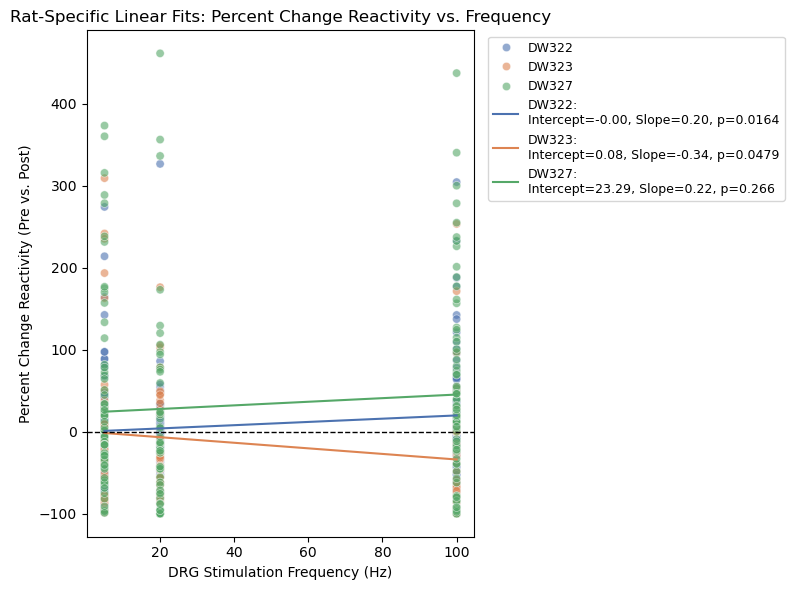


=== DW322 ===
                                OLS Regression Results                               
Dep. Variable:     percent_change_reactivity   R-squared:                       0.020
Model:                                   OLS   Adj. R-squared:                  0.017
Method:                        Least Squares   F-statistic:                     5.828
Date:                       Thu, 20 Mar 2025   Prob (F-statistic):             0.0164
Time:                               11:46:25   Log-Likelihood:                -1574.1
No. Observations:                        287   AIC:                             3152.
Df Residuals:                            285   BIC:                             3159.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [46]:
result_dict, filtered_df = analyze_rat_specific_slopes(lmem_percent, -500, 500)
for rat, info in result_dict.items():
    print(f"\n=== {rat} ===")
    print(info["ols_summary"])

## ⚠️ (wip) - trying to get model to converge with random intercept AND slope

model may not be converging... may need more data or may be unsolveable

In [47]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def analyze_mixed_model_random_slopes(lmem_percent, lower_bound, upper_bound):
    """
    Fit a random-intercept, random-slope mixed model where each rat gets its
    own intercept and slope. Then plot a separate line for each rat with an
    approximate p-value for that rat's slope.

    Steps:
      1) Compute percent_change_reactivity from pre/post.
      2) Filter by user-specified bounds.
      3) Convert Frequency_Hz to numeric for a continuous predictor.
      4) Fit a mixed model: 
         percent_change_reactivity ~ Frequency_Hz_numeric 
         + (1 + Frequency_Hz_numeric | Rat_ID).
      5) Extract each rat's intercept & slope from result.random_effects.
      6) Approximate a p-value for each slope using a Wald-like approach.
      7) Plot lines and raw data.

    Returns:
      result: The fitted MixedLM model.
      filtered: The DataFrame used for fitting.
      per_rat_df: Table of intercepts, slopes, and approximate p-values.
    """
    # 1) Compute percent_change_reactivity
    def compute_pct_change(row):
        if row["pre-stim"] == 0:
            return np.nan
        return 100 * (row["post-stim"] - row["pre-stim"]) / abs(row["pre-stim"])

    # Copy to avoid mutating original
    df = lmem_percent.copy()
    df["percent_change_reactivity"] = df.apply(compute_pct_change, axis=1)

    # 2) Filter by bounds
    filtered = df[
        (df["percent_change_reactivity"] >= lower_bound) &
        (df["percent_change_reactivity"] <= upper_bound)
    ].copy()

    filtered["percent_change_reactivity"] = pd.to_numeric(filtered["percent_change_reactivity"], errors="coerce")
    filtered = filtered.dropna(subset=["percent_change_reactivity"]).reset_index(drop=True)

    # 3) Convert Frequency_Hz to numeric
    filtered["Frequency_Hz_numeric"] = pd.to_numeric(filtered["Frequency_Hz"], errors="coerce")
    filtered = filtered.dropna(subset=["Frequency_Hz_numeric"]).reset_index(drop=True)

    # 4) Fit a random-intercept, random-slope mixed model
    # Model formula: 
    #   percent_change_reactivity ~ Frequency_Hz_numeric
    # Groups = Rat_ID
    # random slopes for Frequency_Hz_numeric
    model = smf.mixedlm(
        formula="percent_change_reactivity ~ Frequency_Hz_numeric",
        data=filtered,
        groups=filtered["Rat_ID"],
        re_formula="~1 + Frequency_Hz_numeric"  # explicitly include intercept + slope
    )
    result = model.fit()

    # 5) Extract each rat's intercept & slope
    # The total intercept for rat r = fixed_intercept + random_intercept[r]
    # The total slope for rat r = fixed_slope + random_slope[r]
    # random_effects is a dict keyed by Rat_ID
    # each value is a dict with keys like "Intercept" and "Frequency_Hz_numeric"
    fixed_intercept = result.params["Intercept"]
    fixed_slope = result.params["Frequency_Hz_numeric"]
    per_rat = []
    for rat_id, reffs in result.random_effects.items():
        # random intercept
        ri = reffs.get("Intercept", 0.0)
        # random slope
        rs = reffs.get("Frequency_Hz_numeric", 0.0)
        intercept_r = fixed_intercept + ri
        slope_r = fixed_slope + rs
        per_rat.append((rat_id, intercept_r, slope_r))
    per_rat_df = pd.DataFrame(per_rat, columns=["Rat_ID", "Intercept", "Slope"])

    # 6) Approximate a p-value for each slope
    # We do a naive Wald test using the random slope variance & the fixed slope variance:
    # slope_r Var ~ Var(fixed_slope) + Var(random_slope_r) + 2 Cov(...)
    # statsmodels stores random effects covariance in result.cov_re and overall
    # var-cov for the fixed effect in result.cov_params().
    # We'll do an approximate linear combination. This is best-effort only.
    
    # Extract var(fixed_slope) from the 2x2 cov_params
    var_fixed_slope = result.cov_params().loc["Frequency_Hz_numeric", "Frequency_Hz_numeric"]
    # Extract random slope variance from result.cov_re if present
    # (if the random effects covariance is 2x2 for [Intercept, Frequency_Hz_numeric])
    # We'll interpret result.cov_re as the average random effect variance
    # but random slopes differ by rat_id. For a more nuanced approach, you'd 
    # examine result.random_effects_cov
    if "Frequency_Hz_numeric" in result.cov_re.columns:
        var_random_slope = result.cov_re.loc["Frequency_Hz_numeric", "Frequency_Hz_numeric"]
        cov_slope_is = result.cov_re.loc["Intercept", "Frequency_Hz_numeric"]
    else:
        var_random_slope = 0.0
        cov_slope_is = 0.0

    # We'll assume no correlation between the fixed slope and random slope in the 
    # classical sense, though it's an approximation. If you want 
    # to incorporate that, you'd do more advanced combining.
    
    # For each rat, the best linear unbiased predictor for slope is slope_r. 
    # We'll do a naive standard error:
    #  SE(slope_r) ~ sqrt(var_fixed_slope + var_random_slope).
    # This omits cross-terms, but can show how you'd approximate.
    
    approx_slope_se = np.sqrt(var_fixed_slope + var_random_slope)
    
    # Then Z = slope_r / SE -> p-value
    from scipy.stats import norm
    zs = []
    ps = []
    for idx, row in per_rat_df.iterrows():
        slope_r = row["Slope"]
        z_val = slope_r / (approx_slope_se if approx_slope_se != 0 else 1e-9)
        p_val = 2 * (1 - norm.cdf(abs(z_val)))
        zs.append(z_val)
        ps.append(p_val)
    per_rat_df["Z_slope_approx"] = zs
    per_rat_df["p_slope_approx"] = ps
    
    # 7) Plot lines per rat & raw data
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=filtered,
        x="Frequency_Hz_numeric",
        y="percent_change_reactivity",
        hue="Rat_ID",
        alpha=0.6
    )
    unique_rats = per_rat_df["Rat_ID"].unique()
    color_map = dict(zip(unique_rats, sns.color_palette("deep", n_colors=len(unique_rats))))
    
    # Make a frequency grid for entire data range
    freq_min = filtered["Frequency_Hz_numeric"].min()
    freq_max = filtered["Frequency_Hz_numeric"].max()
    x_grid = np.linspace(freq_min, freq_max, 50)
    
    # For each rat, build a separate line
    lines_labels = []
    for idx, row in per_rat_df.iterrows():
        rat_id = row["Rat_ID"]
        intercept_r = row["Intercept"]
        slope_r = row["Slope"]
        p_approx = row["p_slope_approx"]
        color = color_map[rat_id]
        
        y_line = intercept_r + slope_r * x_grid
        label_str = f"{rat_id}:\nIntercept={intercept_r:.2f}, Slope={slope_r:.2f}, p~{p_approx:.3g}"
        
        plt.plot(x_grid, y_line, color=color, label=label_str)
        lines_labels.append(label_str)
    
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("DRG Stimulation Frequency (Hz)")
    plt.ylabel("Percent Change Reactivity (Pre vs Post)")
    plt.title("Random-Slope Mixed Model: Separate Lines per Rat")
    plt.legend(loc="upper left", fontsize=9, bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

    return result, filtered, per_rat_df


**Mixed Model Formula (Random Slope per Rat)**

$$
\begin{aligned}
\text{percent\_change\_reactivity} 
&\sim \beta_0 + \beta_1 \times \text{Frequency\_Hz\_numeric} 
 \\
u_{0r} &\sim N(0,\,\sigma_{0}^2), \quad u_{1r} \sim N(0,\,\sigma_{1}^2), \\
\text{with correlation } &\rho \text{ if included.}
\end{aligned}
$$

Where each rat \(r\) has:

- **Random Intercept** $u_{0r}$.
- **Random Slope** $u_{1r}$ for $ \text{Frequency\_Hz\_numeric}$.


Thus, the model for rat \(r\) is:

$$
(\beta_0 + u_{0r}) + (\beta_1 + u_{1r}) \times \text{Frequency\_Hz\_numeric}.
$$


In [48]:
# Suppose lmem_percent is your dataset
result, filtered, per_rat_df = analyze_mixed_model_random_slopes(lmem_percent, -1000, 1000)

print(result.summary())        # MixedLM global summary
print("\nApproximate random slope stats per rat:")
print(per_rat_df)

c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

KeyError: 'Intercept'

In [ ]:
print("Random-effects covariance matrix:\n", result.cov_re)
